# CIFAR-10: Baseline vs Dendritic Optimization Comparison

## Part 1: Configuration & Setup

### 1.1 Install Dependencies

In [1]:
# Install PerforatedAI
# !pip install pytorch -q
!pip install perforatedai -q
!pip install perforatedbp -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.6 MB/s eta 0:00:0000:0100:01


### 1.2 Imports

In [2]:
import sys
import platform
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pdb
from IPython.display import display

# Disable pdb to prevent hanging in cloud environments
pdb.set_trace = lambda: None

%matplotlib inline

from perforatedai import globals_perforatedai as GPA
from perforatedai import utils_perforatedai as UPA

Building dendrites with Perforated Backpropagation


### 1.3 Configuration Parameters

In [18]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================

# General Training Parameters
SEED = 42
BATCH_SIZE = 128
NUM_EPOCHS = 120
LEARNING_RATE = 0.006
NUM_CLASSES = 10
NUM_WORKERS = 2

# Data Normalization
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
CIFAR10_CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Baseline Model (Large)
LARGE_CONV1 = 32
LARGE_CONV2 = 64
LARGE_FC = 512

# PAI Model (Small Base)
SMALL_CONV1 = 16
SMALL_CONV2 = 32
SMALL_FC = 256

DROPOUT_CONV = 0.2
DROPOUT_FC = 0.4

SCHEDULER_PATIENCE = 5
SCHEDULER_FACTOR = 0.5

# PAI Config
PAI_EPOCHS_TO_SWITCH = 4
PAI_HISTORY_LOOKBACK = 3
PAI_MAX_DENDRITES = 10
PAI_MAX_DENDRITE_TRIES = 60
PAI_SCHEDULER_PATIENCE = 3        
PAI_IMPROVEMENT_THRESHOLD = 0.3
PAI_PERFORATED_BACKPROP = True

### 1.4 Environment Info & Device Setup

In [4]:
# Environment Info
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Platform: {platform.system()} {platform.machine()}")
print(f"CPU cores: {os.cpu_count()}")

# Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("GPU: Apple MPS")
else:
    device = torch.device('cpu')
    print("GPU: None (using CPU)")

print(f"Device: {device}")

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
Platform: Linux x86_64
CPU cores: 4
GPU: Tesla P100-PCIE-16GB
CUDA: 12.6
Device: cuda


### 1.5 Data Loading

In [5]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Load CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s] 


Training samples: 50000
Test samples: 10000


### 1.6 Model Architecture Definition

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, c1, c2, fc, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size=3, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(),
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(DROPOUT_CONV),
            
            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
            nn.Conv2d(c2, c2, kernel_size=3, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(DROPOUT_CONV),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c2 * 8 * 8, fc),
            nn.ReLU(),
            nn.Dropout(DROPOUT_FC),
            nn.Linear(fc, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

import numpy
import torch.serialization

torch.serialization.add_safe_globals([
    (numpy._core.multiarray.scalar, 'numpy.core.multiarray.scalar'),
    numpy.dtype,
    numpy.dtypes.Float64DType
])

print("Model class defined and allowlisted for serialization")

Model class defined and allowlisted for serialization


### 1.7 Training and Evaluation Functions

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device, return_per_class=False):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    overall_loss = running_loss / len(loader)
    overall_acc = 100. * accuracy_score(all_targets, all_predictions)
    
    # Calculate Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='macro', zero_division=0
    )
    
    metrics = {
        'loss': overall_loss,
        'accuracy': overall_acc,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100
    }
    
    if return_per_class:
        # Per-class accuracy
        per_class_acc = {}
        for i in range(NUM_CLASSES):
            indices = [idx for idx, t in enumerate(all_targets) if t == i]
            if indices:
                class_correct = sum(1 for idx in indices if all_predictions[idx] == i)
                per_class_acc[CIFAR10_CLASSES[i]] = 100. * class_correct / len(indices)
            else:
                per_class_acc[CIFAR10_CLASSES[i]] = 0.0
        return metrics, per_class_acc
    
    return metrics

## Part 2: Baseline Model Training

### 2.1 Initialize Baseline Model

In [9]:
# Reset seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Initialize LARGE baseline model
baseline_model = SimpleCNN(LARGE_CONV1, LARGE_CONV2, LARGE_FC, NUM_CLASSES).to(device)
baseline_criterion = nn.CrossEntropyLoss()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
baseline_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    baseline_optimizer, mode='max', patience=PAI_SCHEDULER_PATIENCE, factor=SCHEDULER_FACTOR
)

print(f"Traditional Network Baseline (LARGE) Parameters: {count_parameters(baseline_model):,}")

Traditional Network Baseline (LARGE) Parameters: 2,168,746


### 2.2 Train Baseline Model

In [12]:
print("="*60)
print("TRAINING BASELINE MODEL")
print("="*60)

baseline_history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': [],
    'test_precision': [], 'test_f1': [],
    'epoch_time': [], 'per_class_acc': []
}

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_acc = train_epoch(baseline_model, train_loader, baseline_criterion, baseline_optimizer, device)
    test_metrics, per_class_acc = evaluate(baseline_model, test_loader, baseline_criterion, device, return_per_class=True)
    baseline_scheduler.step(test_metrics['accuracy'])
    
    epoch_time = time.time() - epoch_start
    
    baseline_history['train_loss'].append(train_loss)
    baseline_history['train_acc'].append(train_acc)
    baseline_history['test_loss'].append(test_metrics['loss'])
    baseline_history['test_acc'].append(test_metrics['accuracy'])
    baseline_history['test_precision'].append(test_metrics['precision'])
    baseline_history['test_f1'].append(test_metrics['f1'])
    baseline_history['epoch_time'].append(epoch_time)
    baseline_history['per_class_acc'].append(per_class_acc)

    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Train Acc: {train_acc:.2f}% | Test Acc: {test_metrics['accuracy']:.2f}% | Time: {epoch_time:.1f}s")

baseline_total_time = time.time() - start_time
baseline_best_acc = max(baseline_history['test_acc'])
baseline_final_acc = baseline_history['test_acc'][-1]
baseline_final_per_class = baseline_history['per_class_acc'][-1]
baseline_final_precision = baseline_history['test_precision'][-1]
baseline_final_f1 = baseline_history['test_f1'][-1]

print(f"\nBaseline Training Complete")
print(f"Best Test Accuracy: {baseline_best_acc:.2f}%")
print(f"Final Test Accuracy: {baseline_final_acc:.2f}%")
print(f"Total Time: {baseline_total_time:.1f}s")
print(f"\nPer-Class Accuracy (Final):")
for class_name, acc in baseline_final_per_class.items():
    print(f"  {class_name:12s}: {acc:.2f}%")

TRAINING BASELINE MODEL
Epoch 01/120 | Train Acc: 22.48% | Test Acc: 28.30% | Time: 13.2s
Epoch 02/120 | Train Acc: 28.23% | Test Acc: 40.39% | Time: 12.2s
Epoch 04/120 | Train Acc: 42.77% | Test Acc: 55.08% | Time: 12.3s
Epoch 06/120 | Train Acc: 51.09% | Test Acc: 61.33% | Time: 12.4s
Epoch 08/120 | Train Acc: 56.60% | Test Acc: 65.72% | Time: 12.0s
Epoch 10/120 | Train Acc: 60.63% | Test Acc: 70.27% | Time: 12.2s
Epoch 12/120 | Train Acc: 62.88% | Test Acc: 71.66% | Time: 11.7s
Epoch 14/120 | Train Acc: 65.21% | Test Acc: 72.90% | Time: 11.5s
Epoch 16/120 | Train Acc: 67.22% | Test Acc: 73.76% | Time: 12.1s
Epoch 18/120 | Train Acc: 68.17% | Test Acc: 75.51% | Time: 11.8s
Epoch 20/120 | Train Acc: 69.95% | Test Acc: 76.55% | Time: 12.0s
Epoch 22/120 | Train Acc: 70.75% | Test Acc: 76.47% | Time: 11.7s
Epoch 24/120 | Train Acc: 71.42% | Test Acc: 77.65% | Time: 11.8s
Epoch 26/120 | Train Acc: 72.27% | Test Acc: 76.97% | Time: 11.9s
Epoch 28/120 | Train Acc: 73.03% | Test Acc: 77.29% 

### 2.3 Baseline Model Visualization

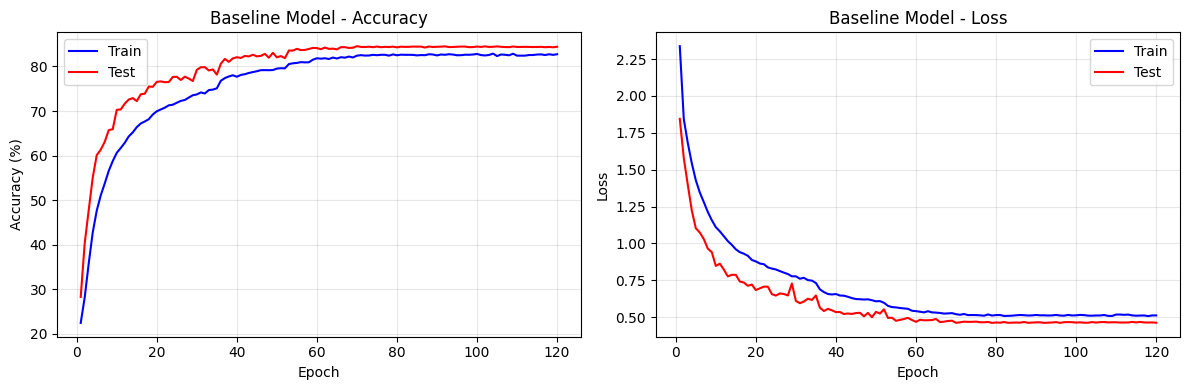

In [13]:
# Baseline Visualization
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 4))

epochs_range = range(1, len(baseline_history['train_acc']) + 1)

# Accuracy plot
axes1[0].plot(epochs_range, baseline_history['train_acc'], 'b-', label='Train')
axes1[0].plot(epochs_range, baseline_history['test_acc'], 'r-', label='Test')
axes1[0].set_xlabel('Epoch')
axes1[0].set_ylabel('Accuracy (%)')
axes1[0].set_title('Baseline Model - Accuracy')
axes1[0].legend()
axes1[0].grid(True, alpha=0.3)

# Loss plot
axes1[1].plot(epochs_range, baseline_history['train_loss'], 'b-', label='Train')
axes1[1].plot(epochs_range, baseline_history['test_loss'], 'r-', label='Test')
axes1[1].set_xlabel('Epoch')
axes1[1].set_ylabel('Loss')
axes1[1].set_title('Baseline Model - Loss')
axes1[1].legend()
axes1[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Baseline_Performance.png', dpi=300)
display(fig1)
# plt.show()

## Part 3: Dendritic Optimization Model (PerforatedAI)

### 3.1 Configure PAI Settings

In [19]:
# Disable debugger breakpoints and testing modes
GPA.pc.set_testing_dendrite_capacity(False)
GPA.pc.set_verbose(False)
GPA.pc.set_silent(True)
GPA.pc.set_weight_decay_accepted(True)
GPA.pc.set_unwrapped_modules_confirmed(True)

# Dendrite optimization settings (using config parameters)
GPA.pc.set_switch_mode(GPA.pc.DOING_HISTORY)
GPA.pc.set_n_epochs_to_switch(PAI_EPOCHS_TO_SWITCH)
GPA.pc.set_history_lookback(PAI_HISTORY_LOOKBACK)
GPA.pc.set_max_dendrites(PAI_MAX_DENDRITES)
GPA.pc.set_max_dendrite_tries(PAI_MAX_DENDRITE_TRIES)
GPA.pc.set_improvement_threshold(PAI_IMPROVEMENT_THRESHOLD)
GPA.pc.set_retain_all_dendrites(False)  
GPA.pc.set_perforated_backpropagation(PAI_PERFORATED_BACKPROP)
# GPA.pc.set_learn_dendrites_live(True)
# GPA.pc.set_using_safe_tensors(False)

# Module configuration - convert BOTH Conv2d and Linear layers
GPA.pc.set_modules_to_convert([nn.Conv2d, nn.Linear])
GPA.pc.set_modules_to_track([nn.BatchNorm2d])

# Set output dimensions for both layer types
GPA.pc.set_output_dimensions([-1, 0, -1, -1]) # Target Conv2d (Batch, Channel, H, W)

print("PAI Configuration Complete")
print(f"Max dendrites: {GPA.pc.get_max_dendrites()}")
print(f"Perforated Backprop: {GPA.pc.get_perforated_backpropagation()}")
print(f"Improvement Threshold: {GPA.pc.get_improvement_threshold()}")

PAI Configuration Complete
Max dendrites: 10
Perforated Backprop: True
Improvement Threshold: 0.3


### 3.2 Initialize PAI Model

In [20]:
# Create and initialize PAI model (Small model architecture)
# Reset seed for fair comparison
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create fresh model with small architecture
pai_model = SimpleCNN(SMALL_CONV1, SMALL_CONV2, SMALL_FC, NUM_CLASSES)

# Initialize PAI - this adds dendrite scaffolding to the model
pai_model = UPA.initialize_pai(
    pai_model,
    doing_pai=True,
    save_name="CIFAR10_PAI",
    making_graphs=True,  
    maximizing_score=True,
    num_classes=NUM_CLASSES
)

# Manually set output dimensions for Linear layers to ensure no mismatch
# Conv2d layers will use the global [-1, 0, -1, -1] set in PAI Configuration
for name, module in pai_model.named_modules():
    if isinstance(module, nn.Linear):
        if hasattr(module, 'set_this_output_dimensions'):
            module.set_this_output_dimensions([-1, 0])
    elif isinstance(module, (nn.Conv2d, nn.Conv1d)):
        if hasattr(module, 'set_this_output_dimensions'):
            module.set_this_output_dimensions([-1, 0, -1, -1])

pai_model = pai_model.to(device)
print(f"Dendritic Optimized Network Initial Parameters: {count_parameters(pai_model):,}")

Dendritic Optimized Network Initial Parameters: 1,087,732


### 3.3 Setup PAI Optimizer

In [21]:
pai_criterion = nn.CrossEntropyLoss()

# Set optimizer and scheduler types for PAI
GPA.pai_tracker.set_optimizer(optim.Adam)
GPA.pai_tracker.set_scheduler(optim.lr_scheduler.ReduceLROnPlateau)

# Configure optimizer and scheduler arguments
optimArgs = {
    'params': pai_model.parameters(),
    'lr': LEARNING_RATE
}
schedArgs = {
    'mode': 'max',
    'patience': PAI_SCHEDULER_PATIENCE,
    'factor': SCHEDULER_FACTOR
}

# Initialize through PAI tracker
pai_optimizer, pai_scheduler = GPA.pai_tracker.setup_optimizer(pai_model, optimArgs, schedArgs)

print("PAI Optimizer and Scheduler configured")

PAI Optimizer and Scheduler configured


### 3.4 Train PAI Model

In [22]:
print("="*60)
print("TRAINING PAI MODEL WITH DENDRITIC OPTIMIZATION")
print("="*60)

pai_history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': [],
    'test_precision': [], 'test_f1': [],
    'epoch_time': [], 'dendrite_count': [],
    'param_count': [], 'per_class_acc': []
}

start_time = time.time()
epoch = 0

# PAI uses infinite loop - breaks when training_complete=True
while True:
    epoch_start = time.time()
    
    # Training
    pai_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        pai_optimizer.zero_grad()
        outputs = pai_model(inputs)
        loss = pai_criterion(outputs, targets)
        loss.backward()
        pai_optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Evaluation with comprehensive metrics
    test_metrics, per_class_acc = evaluate(pai_model, test_loader, pai_criterion, device, return_per_class=True)

    # Step scheduler manually to match baseline behavior
    pai_scheduler.step(test_metrics['accuracy'])
    
    # PAI validation score - this is where dendrites get added
    pai_model, restructured, training_complete = GPA.pai_tracker.add_validation_score(
        test_metrics['accuracy'], pai_model
    )
    pai_model = pai_model.to(device)
    
    # Handle restructuring (dendrites added)
    if restructured:
        optimArgs = {'params': pai_model.parameters(), 'lr': LEARNING_RATE}
        schedArgs = {'mode': 'max', 'patience': PAI_SCHEDULER_PATIENCE, 'factor': SCHEDULER_FACTOR}
        pai_optimizer, pai_scheduler = GPA.pai_tracker.setup_optimizer(pai_model, optimArgs, schedArgs)
        dendrite_count = GPA.pai_tracker.member_vars.get("num_dendrites_added", 0)
        print(f"  -> Model restructured. Dendrites: {dendrite_count}")
    
    epoch_time = time.time() - epoch_start
    dendrite_count = GPA.pai_tracker.member_vars.get("num_dendrites_added", 0)
    
    pai_history['train_loss'].append(train_loss)
    pai_history['train_acc'].append(train_acc)
    pai_history['test_loss'].append(test_metrics['loss'])
    pai_history['test_acc'].append(test_metrics['accuracy'])
    pai_history['test_precision'].append(test_metrics['precision'])
    pai_history['test_f1'].append(test_metrics['f1'])
    pai_history['epoch_time'].append(epoch_time)
    pai_history['dendrite_count'].append(dendrite_count)
    pai_history['param_count'].append(count_parameters(pai_model))
    pai_history['per_class_acc'].append(per_class_acc)

    
    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d} | Train: {train_acc:.2f}% | Test: {test_metrics['accuracy']:.2f}% | Dendrites: {dendrite_count} | Time: {epoch_time:.1f}s")
    
    epoch += 1
    
    if training_complete:
        print("PAI signaled training complete")
        break
    
    if epoch >= NUM_EPOCHS:
        break

pai_total_time = time.time() - start_time
pai_best_acc = max(pai_history['test_acc'])
pai_final_acc = pai_history['test_acc'][-1]
pai_final_precision = pai_history['test_precision'][-1]
pai_final_f1 = pai_history['test_f1'][-1]
pai_final_params = pai_history['param_count'][-1]
pai_final_dendrites = pai_history['dendrite_count'][-1]
pai_final_per_class = pai_history['per_class_acc'][-1]

print(f"\nPAI Training Complete")
print(f"Total Epochs: {epoch}")
print(f"Best Test Accuracy: {pai_best_acc:.2f}%")
print(f"Final Test Accuracy: {pai_final_acc:.2f}%")
print(f"Final Parameters: {pai_final_params:,}")
print(f"Dendrites Added: {pai_final_dendrites}")
print(f"Total Time: {pai_total_time:.1f}s")

TRAINING PAI MODEL WITH DENDRITIC OPTIMIZATION
Epoch 001 | Train: 23.33% | Test: 31.89% | Dendrites: 0 | Time: 12.1s
Epoch 002 | Train: 30.59% | Test: 44.17% | Dendrites: 0 | Time: 12.0s
Epoch 004 | Train: 38.70% | Test: 52.11% | Dendrites: 0 | Time: 12.4s
Epoch 006 | Train: 45.64% | Test: 53.52% | Dendrites: 0 | Time: 12.1s
  -> Model restructured. Dendrites: 0
Epoch 008 | Train: 48.71% | Test: 61.64% | Dendrites: 0 | Time: 13.0s
Epoch 010 | Train: 40.45% | Test: 53.64% | Dendrites: 0 | Time: 15.4s
Epoch 012 | Train: 40.22% | Test: 53.22% | Dendrites: 0 | Time: 15.5s
Epoch 014 | Train: 40.57% | Test: 53.60% | Dendrites: 0 | Time: 15.3s
Epoch 016 | Train: 40.44% | Test: 53.64% | Dendrites: 0 | Time: 15.5s
Epoch 018 | Train: 40.18% | Test: 53.21% | Dendrites: 0 | Time: 15.3s
Epoch 020 | Train: 40.16% | Test: 53.40% | Dendrites: 0 | Time: 15.4s
Epoch 022 | Train: 40.60% | Test: 53.56% | Dendrites: 0 | Time: 15.6s
Epoch 024 | Train: 40.55% | Test: 53.59% | Dendrites: 0 | Time: 15.5s
Epoch

### 3.5 PAI Model Visualization

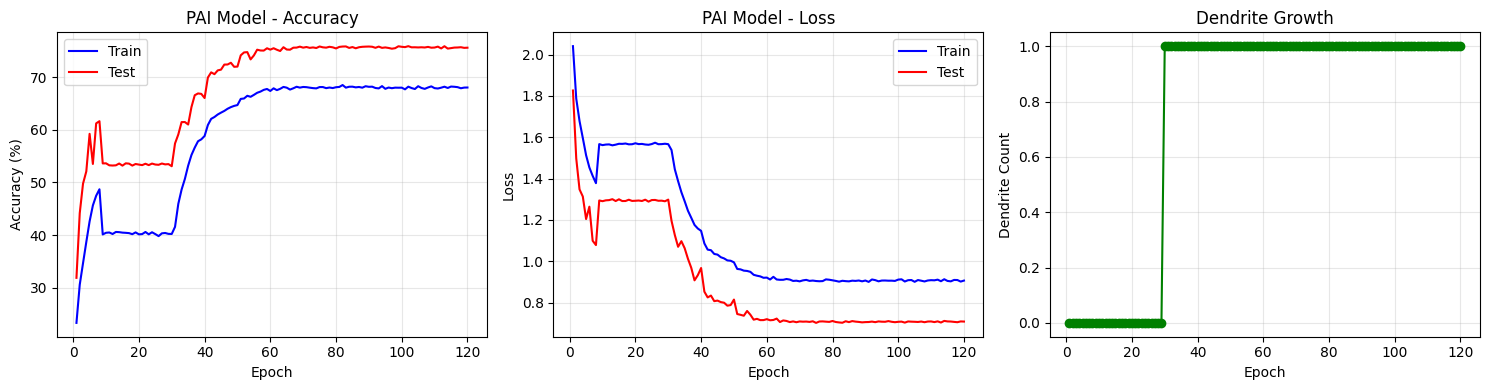

In [23]:
# PAI Model Visualization
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 4))

pai_epochs_range = range(1, len(pai_history['test_acc']) + 1)

# Accuracy plot
axes2[0].plot(pai_epochs_range, pai_history['train_acc'], 'b-', label='Train')
axes2[0].plot(pai_epochs_range, pai_history['test_acc'], 'r-', label='Test')
axes2[0].set_xlabel('Epoch')
axes2[0].set_ylabel('Accuracy (%)')
axes2[0].set_title('PAI Model - Accuracy')
axes2[0].legend()
axes2[0].grid(True, alpha=0.3)

# Loss plot
axes2[1].plot(pai_epochs_range, pai_history['train_loss'], 'b-', label='Train')
axes2[1].plot(pai_epochs_range, pai_history['test_loss'], 'r-', label='Test')
axes2[1].set_xlabel('Epoch')
axes2[1].set_ylabel('Loss')
axes2[1].set_title('PAI Model - Loss')
axes2[1].legend()
axes2[1].grid(True, alpha=0.3)

# Dendrite growth plot
axes2[2].plot(pai_epochs_range, pai_history['dendrite_count'], 'g-', marker='o')
axes2[2].set_xlabel('Epoch')
axes2[2].set_ylabel('Dendrite Count')
axes2[2].set_title('Dendrite Growth')
axes2[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('PAI_Performance.png', dpi=300)
display(fig2)
# plt.show()

## Part 4: Comparison - Baseline vs Dendritic Optimization

### 4.1 Accuracy and Loss Comparison

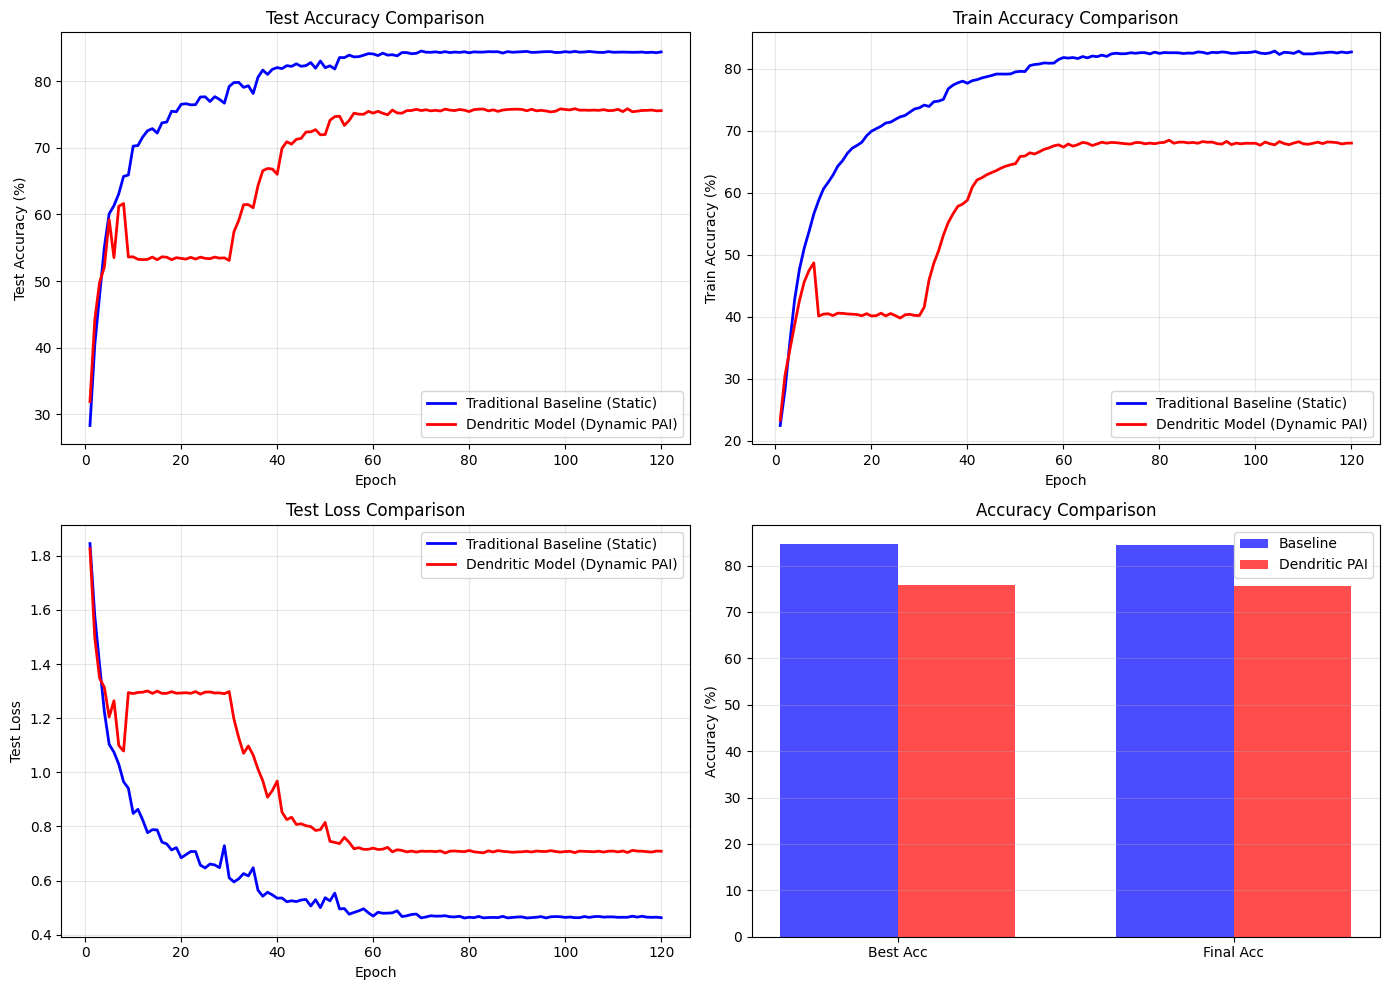

In [24]:
# Comparison: Test Accuracy over Epochs
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 10))

# Use same epoch range for fair comparison
baseline_epochs = range(1, NUM_EPOCHS + 1)
pai_epochs_range = range(1, len(pai_history['test_acc']) + 1)

# Test Accuracy Comparison
axes3[0, 0].plot(baseline_epochs, baseline_history['test_acc'], 'b-', label='Traditional Baseline (Static)', linewidth=2)
axes3[0, 0].plot(pai_epochs_range, pai_history['test_acc'], 'r-', label='Dendritic Model (Dynamic PAI)', linewidth=2)
axes3[0, 0].set_xlabel('Epoch')
axes3[0, 0].set_ylabel('Test Accuracy (%)')
axes3[0, 0].set_title('Test Accuracy Comparison')
axes3[0, 0].legend()
axes3[0, 0].grid(True, alpha=0.3)

# Train Accuracy Comparison
axes3[0, 1].plot(baseline_epochs, baseline_history['train_acc'], 'b-', label='Traditional Baseline (Static)', linewidth=2)
axes3[0, 1].plot(pai_epochs_range, pai_history['train_acc'], 'r-', label='Dendritic Model (Dynamic PAI)', linewidth=2)
axes3[0, 1].set_xlabel('Epoch')
axes3[0, 1].set_ylabel('Train Accuracy (%)')
axes3[0, 1].set_title('Train Accuracy Comparison')
axes3[0, 1].legend()
axes3[0, 1].grid(True, alpha=0.3)

# Test Loss Comparison
axes3[1, 0].plot(baseline_epochs, baseline_history['test_loss'], 'b-', label='Traditional Baseline (Static)', linewidth=2)
axes3[1, 0].plot(pai_epochs_range, pai_history['test_loss'], 'r-', label='Dendritic Model (Dynamic PAI)', linewidth=2)
axes3[1, 0].set_xlabel('Epoch')
axes3[1, 0].set_ylabel('Test Loss')
axes3[1, 0].set_title('Test Loss Comparison')
axes3[1, 0].legend()
axes3[1, 0].grid(True, alpha=0.3)

# Bar chart - Final Metrics
metrics = ['Best Acc', 'Final Acc']
baseline_vals = [baseline_best_acc, baseline_final_acc]
pai_vals = [pai_best_acc, pai_final_acc]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes3[1, 1].bar(x - width/2, baseline_vals, width, label='Baseline', color='blue', alpha=0.7)
bars2 = axes3[1, 1].bar(x + width/2, pai_vals, width, label='Dendritic PAI', color='red', alpha=0.7)

axes3[1, 1].set_ylabel('Accuracy (%)')
axes3[1, 1].set_title('Accuracy Comparison')
axes3[1, 1].set_xticks(x)
axes3[1, 1].set_xticklabels(metrics)
axes3[1, 1].legend()
axes3[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('Comparison_Trends.png', dpi=300)
display(fig3)
# plt.show()

### 4.2 Summary Statistics

In [25]:
# Summary Statistics Table
print("="*90)
print("FINAL COMPARISON SUMMARY: BASELINE vs. DENDRITIC OPTIMIZATION")
print("="*90)
print(f"{'Metric':<30} {'Baseline (Static)':>25} {'Dendritic (PAI)':>25}")
print("-"*90)

print(f"{'Best Test Accuracy':<30} {baseline_best_acc:>24.2f}% {pai_best_acc:>24.2f}%")
print(f"{'Final Test Accuracy':<30} {baseline_final_acc:>24.2f}% {pai_final_acc:>24.2f}%")
print(f"{'Final Macro Precision':<30} {baseline_final_precision:>24.2f}% {pai_final_precision:>24.2f}%")
print(f"{'Final Macro F1-Score':<30} {baseline_final_f1:>24.2f}% {pai_final_f1:>24.2f}%")
print(f"{'Total Epochs':<30} {NUM_EPOCHS:>25} {len(pai_history['test_acc']):>25}")
print(f"{'Final Parameters':<30} {count_parameters(baseline_model):>25,} {pai_final_params:>25,}")
print(f"{'Dendrites Added':<30} {'N/A':>25} {pai_final_dendrites:>25}")
print(f"{'Total Training Time':<30} {baseline_total_time:>24.1f}s {pai_total_time:>24.1f}s")
print("-"*90)

# Calculate improvement of Dendritic model over baseline
accuracy_improvement = pai_best_acc - baseline_best_acc
# Improved error reduction calculation
error_reduction_base = (100 - baseline_best_acc)
if error_reduction_base > 0:
    pai_error_reduction = ((pai_best_acc - baseline_best_acc) / error_reduction_base) * 100
else:
    pai_error_reduction = 0

print(f"\nDendritic Performance Gains:")
print(f"  Accuracy Gain: {accuracy_improvement:+.2f}%")
print(f"  Error Reduction: {pai_error_reduction:.2f}%")
print(f"  Precision Gain: {pai_final_precision - baseline_final_precision:+.2f}%")
print(f"  F1-Score Gain: {pai_final_f1 - baseline_final_f1:+.2f}%")

print(f"\nEfficiency:")
print(f"  Parameter Overhead: {((pai_final_params - count_parameters(baseline_model))/count_parameters(baseline_model))*100:+.2f}%")
print(f"  Accuracy per 1k Params: {pai_best_acc/(pai_final_params/1000):.4f} (PAI) vs {baseline_best_acc/(count_parameters(baseline_model)/1000):.4f} (Baseline)")

FINAL COMPARISON SUMMARY: BASELINE vs. DENDRITIC OPTIMIZATION
Metric                                 Baseline (Static)           Dendritic (PAI)
------------------------------------------------------------------------------------------
Best Test Accuracy                                84.55%                    75.89%
Final Test Accuracy                               84.42%                    75.60%
Final Macro Precision                             84.33%                    75.89%
Final Macro F1-Score                              84.27%                    75.48%
Total Epochs                                         120                       120
Final Parameters                               2,168,746                 1,631,864
Dendrites Added                                      N/A                         1
Total Training Time                              1384.9s                   1620.1s
------------------------------------------------------------------------------------------

Dendriti

### 4.3 Final Comparison Visualization

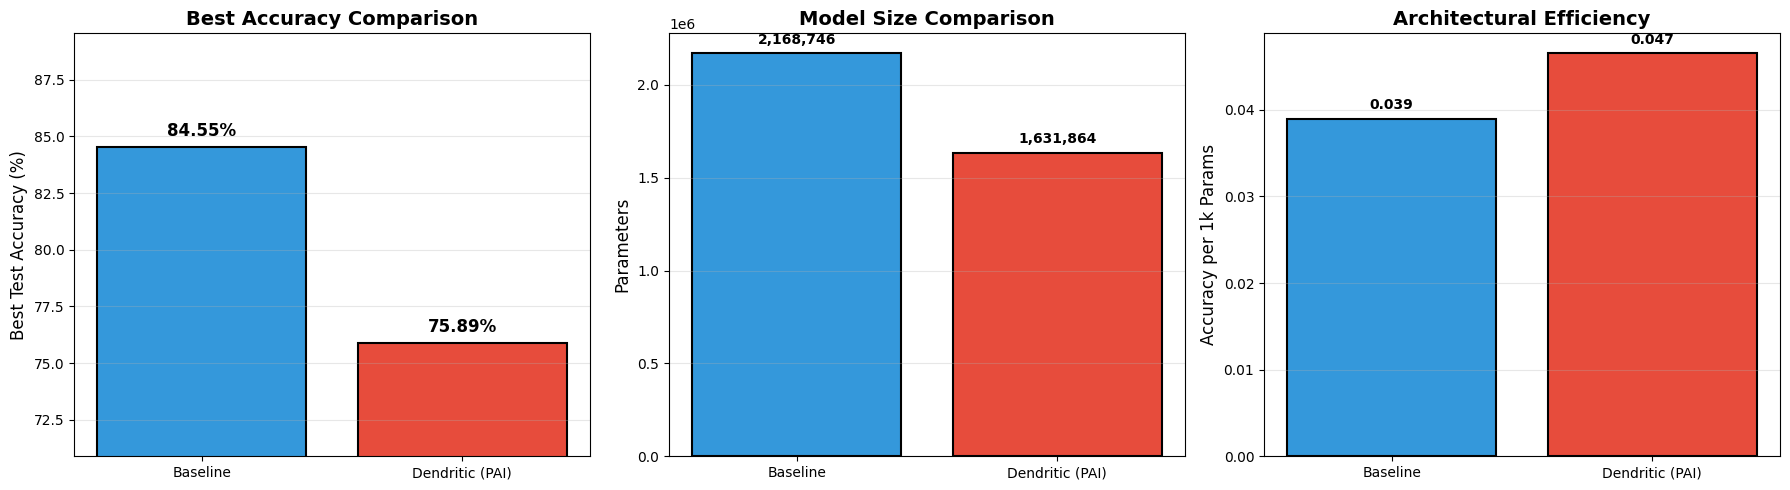

In [26]:
# Final Visualization - 2-Way Comparison
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5))

# 1. Accuracy Comparison 
categories = ['Baseline', 'Dendritic (PAI)']
best_accs = [baseline_best_acc, pai_best_acc]
colors = ['#3498db', '#e74c3c']

bars = axes4[0].bar(categories, best_accs, color=colors, edgecolor='black', linewidth=1.5)
axes4[0].set_ylabel('Best Test Accuracy (%)', fontsize=12)
axes4[0].set_title('Best Accuracy Comparison', fontsize=14, fontweight='bold')
axes4[0].set_ylim([min(best_accs) - 5, max(best_accs) + 5]) # Adjusted for visibility
axes4[0].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, best_accs):
    axes4[0].annotate(f'{acc:.2f}%', xy=(bar.get_x() + bar.get_width()/2, acc),
                     xytext=(0, 5), textcoords="offset points", ha='center', va='bottom',
                     fontsize=12, fontweight='bold')

# 2. Parameter Count Comparison
param_counts = [count_parameters(baseline_model), pai_final_params]
bars2 = axes4[1].bar(categories, param_counts, color=colors, edgecolor='black', linewidth=1.5)
axes4[1].set_ylabel('Parameters', fontsize=12)
axes4[1].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
axes4[1].grid(True, alpha=0.3, axis='y')

for bar, params in zip(bars2, param_counts):
    axes4[1].annotate(f'{params:,}', xy=(bar.get_x() + bar.get_width()/2, params),
                     xytext=(0, 5), textcoords="offset points", ha='center', va='bottom',
                     fontsize=10, fontweight='bold')

# 3. Efficiency (Accuracy / Params ratio normalized)
efficiency = [acc / (params/1000) for acc, params in zip(best_accs, param_counts)]
bars3 = axes4[2].bar(categories, efficiency, color=colors, edgecolor='black', linewidth=1.5)
axes4[2].set_ylabel('Accuracy per 1k Params', fontsize=12)
axes4[2].set_title('Architectural Efficiency', fontsize=14, fontweight='bold')
axes4[2].grid(True, alpha=0.3, axis='y')

for bar, eff in zip(bars3, efficiency):
    axes4[2].annotate(f'{eff:.3f}', xy=(bar.get_x() + bar.get_width()/2, eff),
                     xytext=(0, 5), textcoords="offset points", ha='center', va='bottom',
                     fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('Accuracy Improvement.png', dpi=300)
display(fig4)
# plt.show()

In [27]:
print("\nConclusion:")
base_params = count_parameters(baseline_model)
param_diff_pct = ((pai_final_params - base_params) / base_params) * 100

if pai_best_acc >= (baseline_best_acc - 0.5): # Within 0.5% of baseline
    print(f"1. Dendritic Optimization (PAI) matched or exceeded the baseline accuracy: {pai_best_acc:.2f}% (PAI) vs {baseline_best_acc:.2f}% (Baseline).")
    
    if pai_final_params < base_params:
        print(f"2. Model Efficiency: The dendritic model achieved this performance while being {abs(param_diff_pct):.1f}% SMALLER than the baseline model.")
        print(f"   (PAI: {pai_final_params:,} params vs Baseline: {base_params:,} params)")
    else:
        print(f"2. Parameter usage: The dendritic model used {param_diff_pct:+.1f}% parameters compared to the baseline.")
    
    print(f"3. Error Reduction: Error was reduced by {pai_error_reduction:.2f}% relative to the baseline's best accuracy.")
    print("\nThe results demonstrate that artificial dendrites allow a smaller model to capture complex features that typically require much larger traditional architectures.")
else:
    print(f"Baseline ({baseline_best_acc:.2f}%) performed better than Dendritic ({pai_best_acc:.2f}%).")
    print("Optimization Tips: Consider increasing PAI_MAX_DENDRITES, decreasing PAI_IMPROVEMENT_THRESHOLD, or using more epochs to allow for more dendritic growth.")


Conclusion:
Baseline (84.55%) performed better than Dendritic (75.89%).
Optimization Tips: Consider increasing PAI_MAX_DENDRITES, decreasing PAI_IMPROVEMENT_THRESHOLD, or using more epochs to allow for more dendritic growth.


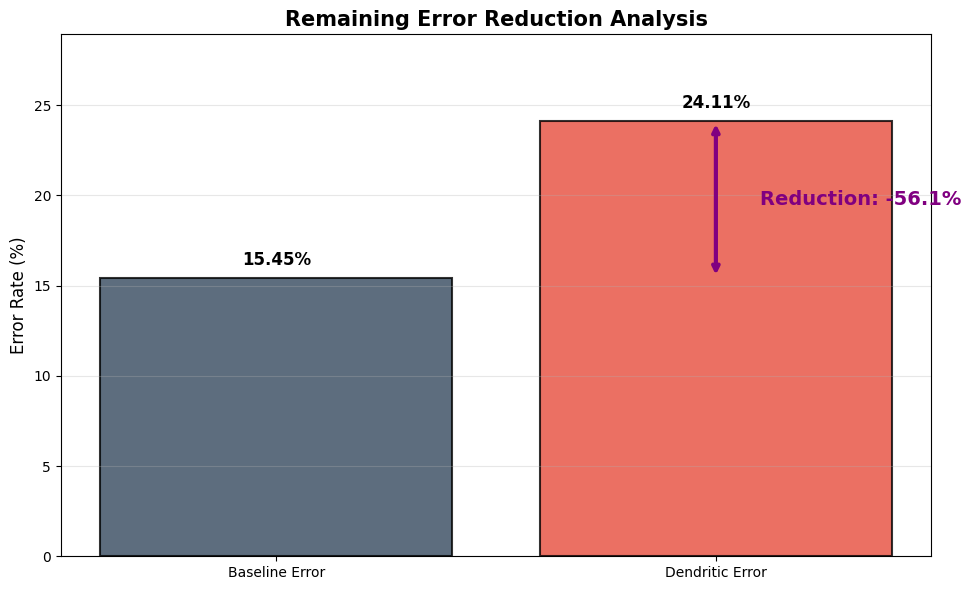

In [28]:
# Error Reduction Visualization
fig_err, ax_err = plt.subplots(figsize=(10, 6))

# Error counts (100 - Accuracy)
error_labels = ['Total Remaining Error', 'Error Eliminated by Dendrites']
error_baseline = 100 - baseline_best_acc
error_pai = 100 - pai_best_acc
error_reduced = error_baseline - error_pai

# Waterfall-style representation of error reduction
bars = ax_err.bar(['Baseline Error', 'Dendritic Error'], [error_baseline, error_pai], 
                color=['#34495e', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)

# Add an arrow or line showing the reduction
ax_err.annotate('', xy=(1, error_pai), xytext=(1, error_baseline),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=3))
ax_err.text(1.1, (error_baseline + error_pai)/2, f'Reduction: {pai_error_reduction:.1f}%', 
         color='purple', fontweight='bold', fontsize=14, va='center')

ax_err.set_ylabel('Error Rate (%)', fontsize=12)
ax_err.set_title('Remaining Error Reduction Analysis', fontsize=15, fontweight='bold')
ax_err.set_ylim([0, max(error_baseline, error_pai) * 1.2])
ax_err.grid(True, axis='y', alpha=0.3)

# Value labels
for bar in bars:
    height = bar.get_height()
    ax_err.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('Remaining Error Reduction.png', dpi=300)
display(fig_err)
# plt.show()

### 4.4 Comprehensive Training Dynamics Visualization

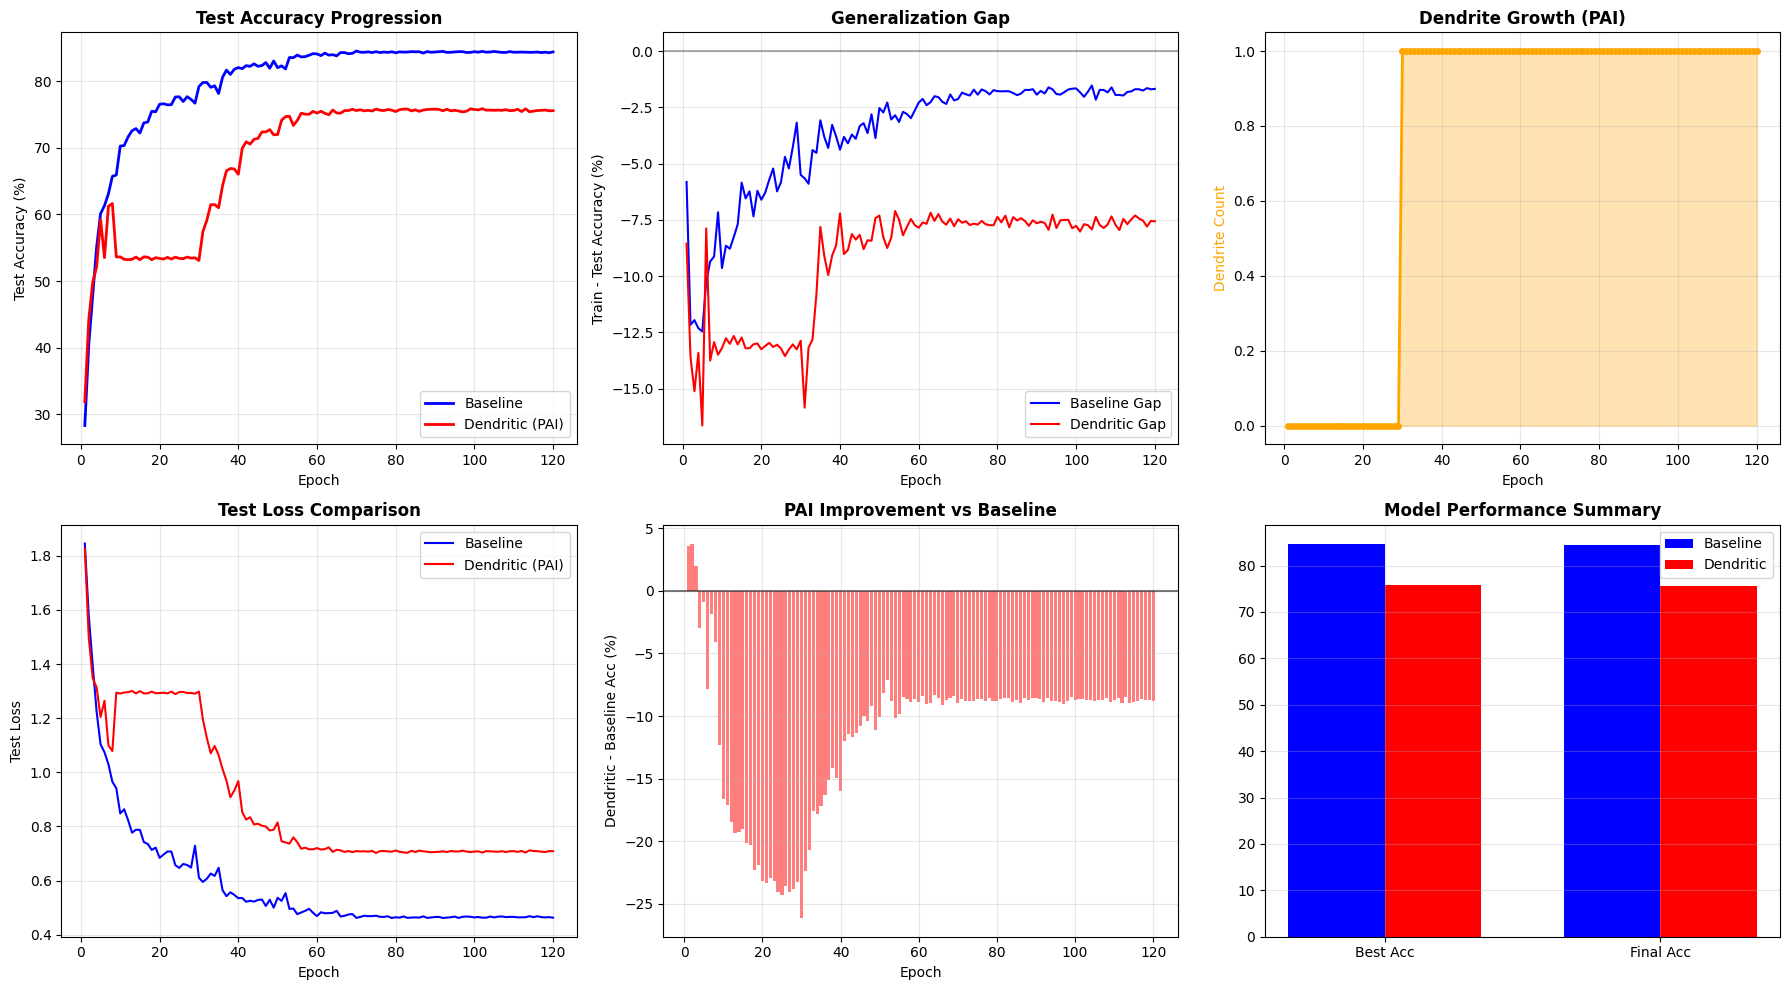

In [29]:
# Comprehensive Training Dynamics - 6 Panel View
fig5, axes5 = plt.subplots(2, 3, figsize=(18, 10))

baseline_epochs_range = range(1, len(baseline_history['test_acc']) + 1)
pai_epochs_range = range(1, len(pai_history['test_acc']) + 1)

# 1. Test Accuracy Over Time
axes5[0, 0].plot(baseline_epochs_range, baseline_history['test_acc'], 'b-', linewidth=2, label='Baseline')
axes5[0, 0].plot(pai_epochs_range, pai_history['test_acc'], 'r-', linewidth=2, label='Dendritic (PAI)')
axes5[0, 0].set_xlabel('Epoch')
axes5[0, 0].set_ylabel('Test Accuracy (%)')
axes5[0, 0].set_title('Test Accuracy Progression', fontweight='bold')
axes5[0, 0].legend()
axes5[0, 0].grid(True, alpha=0.3)

# 2. Training vs Test Accuracy Gap (Overfitting Analysis)
def get_gap(history):
    return [t - v for t, v in zip(history['train_acc'], history['test_acc'])]

axes5[0, 1].plot(baseline_epochs_range, get_gap(baseline_history), 'b-', label='Baseline Gap')
axes5[0, 1].plot(pai_epochs_range, get_gap(pai_history), 'r-', label='Dendritic Gap')
axes5[0, 1].axhline(y=0, color='black', alpha=0.3)
axes5[0, 1].set_xlabel('Epoch')
axes5[0, 1].set_ylabel('Train - Test Accuracy (%)')
axes5[0, 1].set_title('Generalization Gap', fontweight='bold')
axes5[0, 1].legend()
axes5[0, 1].grid(True, alpha=0.3)

# 3. Dendrite Growth
ax3 = axes5[0, 2]
ax3.fill_between(pai_epochs_range, pai_history['dendrite_count'], alpha=0.3, color='orange')
ax3.plot(pai_epochs_range, pai_history['dendrite_count'], 'orange', linewidth=2, marker='o', markersize=4)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Dendrite Count', color='orange')
ax3.set_title('Dendrite Growth (PAI)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Test Loss Comparison
axes5[1, 0].plot(baseline_epochs_range, baseline_history['test_loss'], 'b-', label='Baseline')
axes5[1, 0].plot(pai_epochs_range, pai_history['test_loss'], 'r-', label='Dendritic (PAI)')
axes5[1, 0].set_xlabel('Epoch')
axes5[1, 0].set_ylabel('Test Loss')
axes5[1, 0].set_title('Test Loss Comparison', fontweight='bold')
axes5[1, 0].legend()
axes5[1, 0].grid(True, alpha=0.3)

# 5. Accuracy Delta (PAI vs Baseline)
min_len = min(len(pai_history['test_acc']), len(baseline_history['test_acc']))
delta = [p - b for p, b in zip(pai_history['test_acc'][:min_len], baseline_history['test_acc'][:min_len])]
axes5[1, 1].bar(range(1, min_len + 1), delta, color='red', alpha=0.5)
axes5[1, 1].axhline(y=0, color='black', alpha=0.5)
axes5[1, 1].set_xlabel('Epoch')
axes5[1, 1].set_ylabel('Dendritic - Baseline Acc (%)')
axes5[1, 1].set_title('PAI Improvement vs Baseline', fontweight='bold')
axes5[1, 1].grid(True, alpha=0.3)

# 6. Final Comparisons (Bar)
ax6 = axes5[1, 2]
width = 0.35
x = np.array([0, 1])
ax6.bar(x - width/2, [baseline_best_acc, baseline_final_acc], width, label='Baseline', color='blue')
ax6.bar(x + width/2, [pai_best_acc, pai_final_acc], width, label='Dendritic', color='red')
ax6.set_xticks(x)
ax6.set_xticklabels(['Best Acc', 'Final Acc'])
ax6.set_title('Model Performance Summary', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Comprehensive_Dynamics.png', dpi=300)
display(fig5)
# plt.show()

### 4.5 Statistical Metrics & Performance Radar Chart

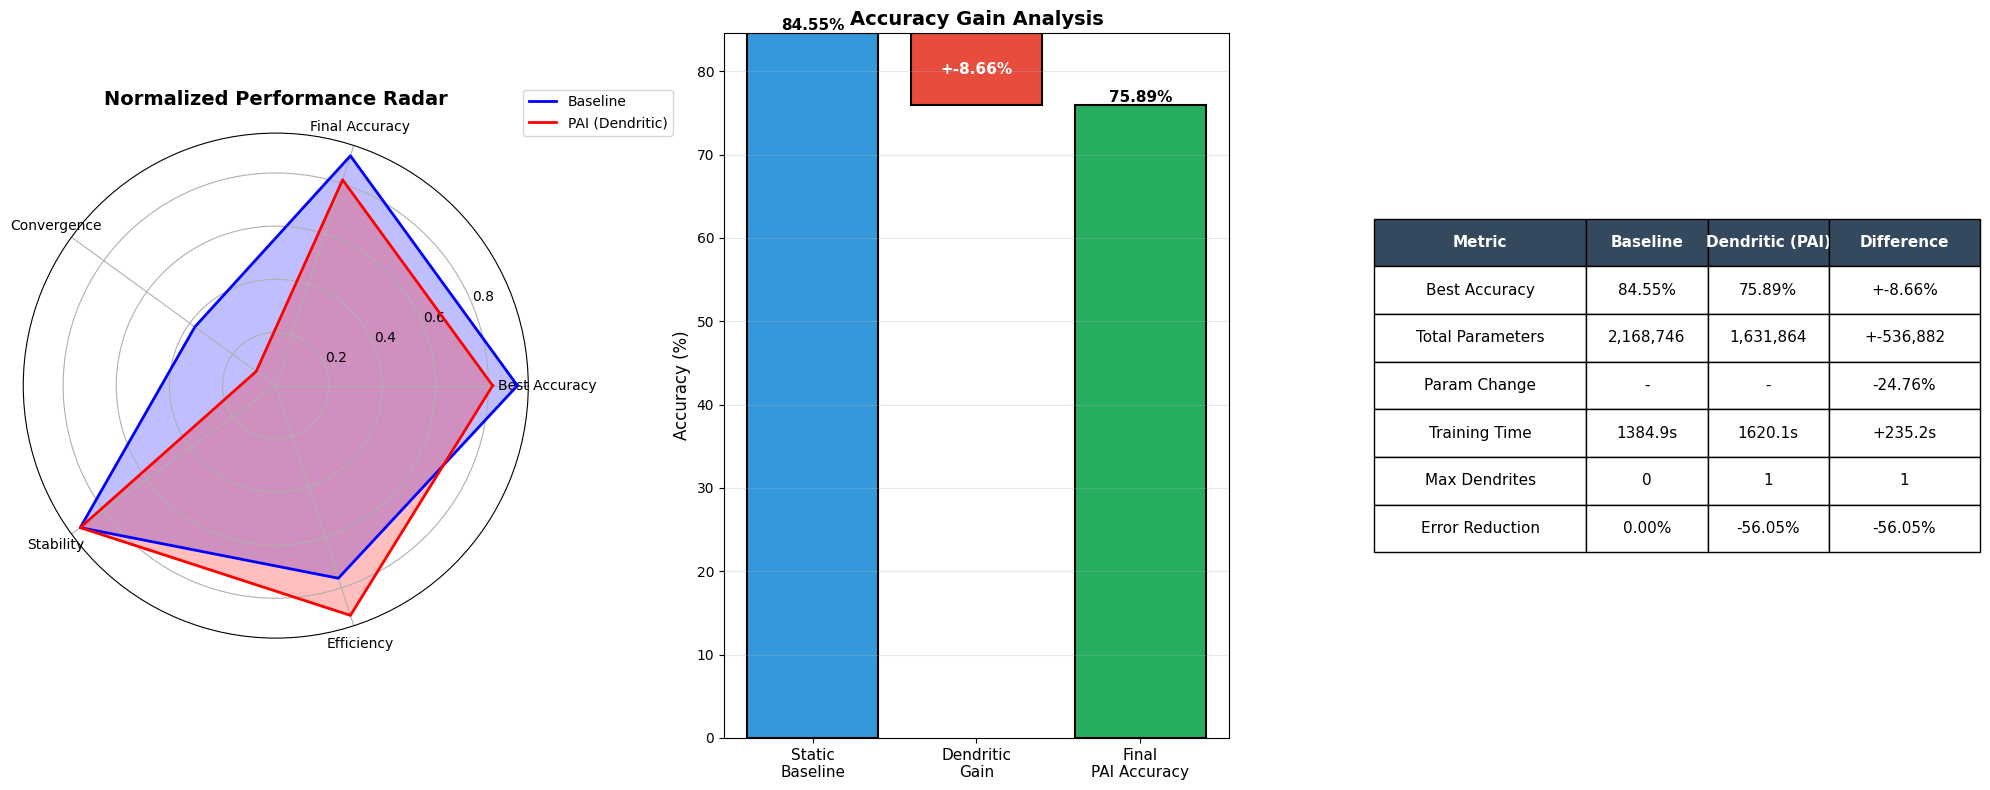

In [30]:
# 4.5 Advanced Performance Analysis
fig6 = plt.figure(figsize=(20, 8))

# 1. Radar Chart for Multi-Metric Comparison
ax11 = fig6.add_subplot(131, projection='polar')

# Metrics to compare
baseline_params = count_parameters(baseline_model)
pai_params = pai_final_params

# Calculate metrics for relative comparison
# Stability: 100 - standard deviation of last 5 epochs
b_stability = 100 - np.std(baseline_history['test_acc'][-5:])
p_history_tail = pai_history['test_acc'][-5:] if len(pai_history['test_acc']) >= 5 else pai_history['test_acc']
p_stability = 100 - np.std(p_history_tail)

metrics = {
    'Best Accuracy': (baseline_best_acc, pai_best_acc),
    'Final Accuracy': (baseline_final_acc, pai_final_acc),
    'Convergence': (
        baseline_history['test_acc'].index(max(baseline_history['test_acc'])) + 1,
        pai_history['test_acc'].index(max(pai_history['test_acc'])) + 1
    ),
    'Stability': (b_stability, p_stability),
    'Efficiency': (
        baseline_best_acc / (baseline_params / 10000),
        pai_best_acc / (pai_params / 10000)
    )
}

# Normalize metrics for radar chart (0-1 scale)
labels = list(metrics.keys())
baseline_values = []
pai_values = []

for label in labels:
    b_val, p_val = metrics[label]
    if label == 'Convergence': # Lower is better, so invert
        max_val = max(b_val, p_val) * 1.1
        baseline_values.append(1.0 - (b_val / max_val))
        pai_values.append(1.0 - (p_val / max_val))
    else:
        max_val = max(b_val, p_val) * 1.1
        baseline_values.append(b_val / max_val if max_val > 0 else 0)
        pai_values.append(p_val / max_val if max_val > 0 else 0)

# Complete the loop for radar chart
baseline_values += baseline_values[:1]
pai_values += pai_values[:1]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

ax11.plot(angles, baseline_values, 'b-', linewidth=2, label='Baseline')
ax11.fill(angles, baseline_values, 'b', alpha=0.25)
ax11.plot(angles, pai_values, 'r-', linewidth=2, label='PAI (Dendritic)')
ax11.fill(angles, pai_values, 'r', alpha=0.25)
ax11.set_xticks(angles[:-1])
ax11.set_xticklabels(labels, fontsize=10)
ax11.set_title('Normalized Performance Radar', fontsize=14, fontweight='bold', pad=20)
ax11.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# 2. Improvement Waterfall Chart
ax21 = fig6.add_subplot(132)
improvements = [
    ('Static\nBaseline', 0, baseline_best_acc),
    ('Dendritic\nGain', baseline_best_acc, pai_best_acc - baseline_best_acc),
    ('Final\nPAI Accuracy', 0, pai_best_acc)
]

x_pos = np.arange(len(improvements))
colors_waterfall = ['#3498db', '#e74c3c', '#27ae60']
bottoms = [0, baseline_best_acc, 0]
heights = [baseline_best_acc, pai_best_acc - baseline_best_acc, pai_best_acc]

bars = ax21.bar(x_pos, heights, bottom=bottoms, color=colors_waterfall, edgecolor='black', linewidth=1.5)

for i, (bar, h, b) in enumerate(zip(bars, heights, bottoms)):
    val = h if i != 1 else h
    label = f'{h:.2f}%' if i != 1 else f'+{h:.2f}%'
    ax21.annotate(label, xy=(bar.get_x() + bar.get_width()/2, b + h/2 if i == 1 else h),
                ha='center', va='center' if i == 1 else 'bottom', 
                fontsize=11, fontweight='bold', color='white' if i == 1 else 'black')

ax21.set_xticks(x_pos)
ax21.set_xticklabels([imp[0] for imp in improvements], fontsize=11)
ax21.set_ylabel('Accuracy (%)', fontsize=12)
ax21.set_title('Accuracy Gain Analysis', fontsize=14, fontweight='bold')
ax21.grid(True, alpha=0.3, axis='y')

# 3. Decision Matrix / Summary Table
ax31 = fig6.add_subplot(133)
ax31.axis('off')

# Ensure calculations for table are robust
accuracy_diff = pai_best_acc - baseline_best_acc
param_diff = pai_final_params - baseline_params
time_diff = pai_total_time - baseline_total_time

table_data = [
    ['Metric', 'Baseline', 'Dendritic (PAI)', 'Difference'],
    ['Best Accuracy', f'{baseline_best_acc:.2f}%', f'{pai_best_acc:.2f}%', f'+{accuracy_diff:.2f}%'],
    ['Total Parameters', f'{baseline_params:,}', f'{pai_final_params:,}', f'+{param_diff:,}'],
    ['Param Change', '-', '-', f'{(param_diff/baseline_params)*100:+.2f}%'],
    ['Training Time', f'{baseline_total_time:.1f}s', f'{pai_total_time:.1f}s', f'+{time_diff:.1f}s'],
    ['Max Dendrites', '0', f'{pai_final_dendrites}', f'{pai_final_dendrites}'],
    ['Error Reduction', '0.00%', f'{pai_error_reduction:.2f}%', f'{pai_error_reduction:.2f}%']
]

table = ax31.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.35, 0.2, 0.2, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.5)

# Style header
for j in range(4):
    table[(0, j)].set_facecolor('#34495e')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('Advanced_Analysis.png', dpi=300)
display(fig6)
# plt.show()

### 4.6 Learning Curve Analysis & Convergence

/tmp/ipykernel_55/4174882883.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax22.boxplot(data_to_plot, labels=['Baseline', 'PAI'], patch_artist=True)


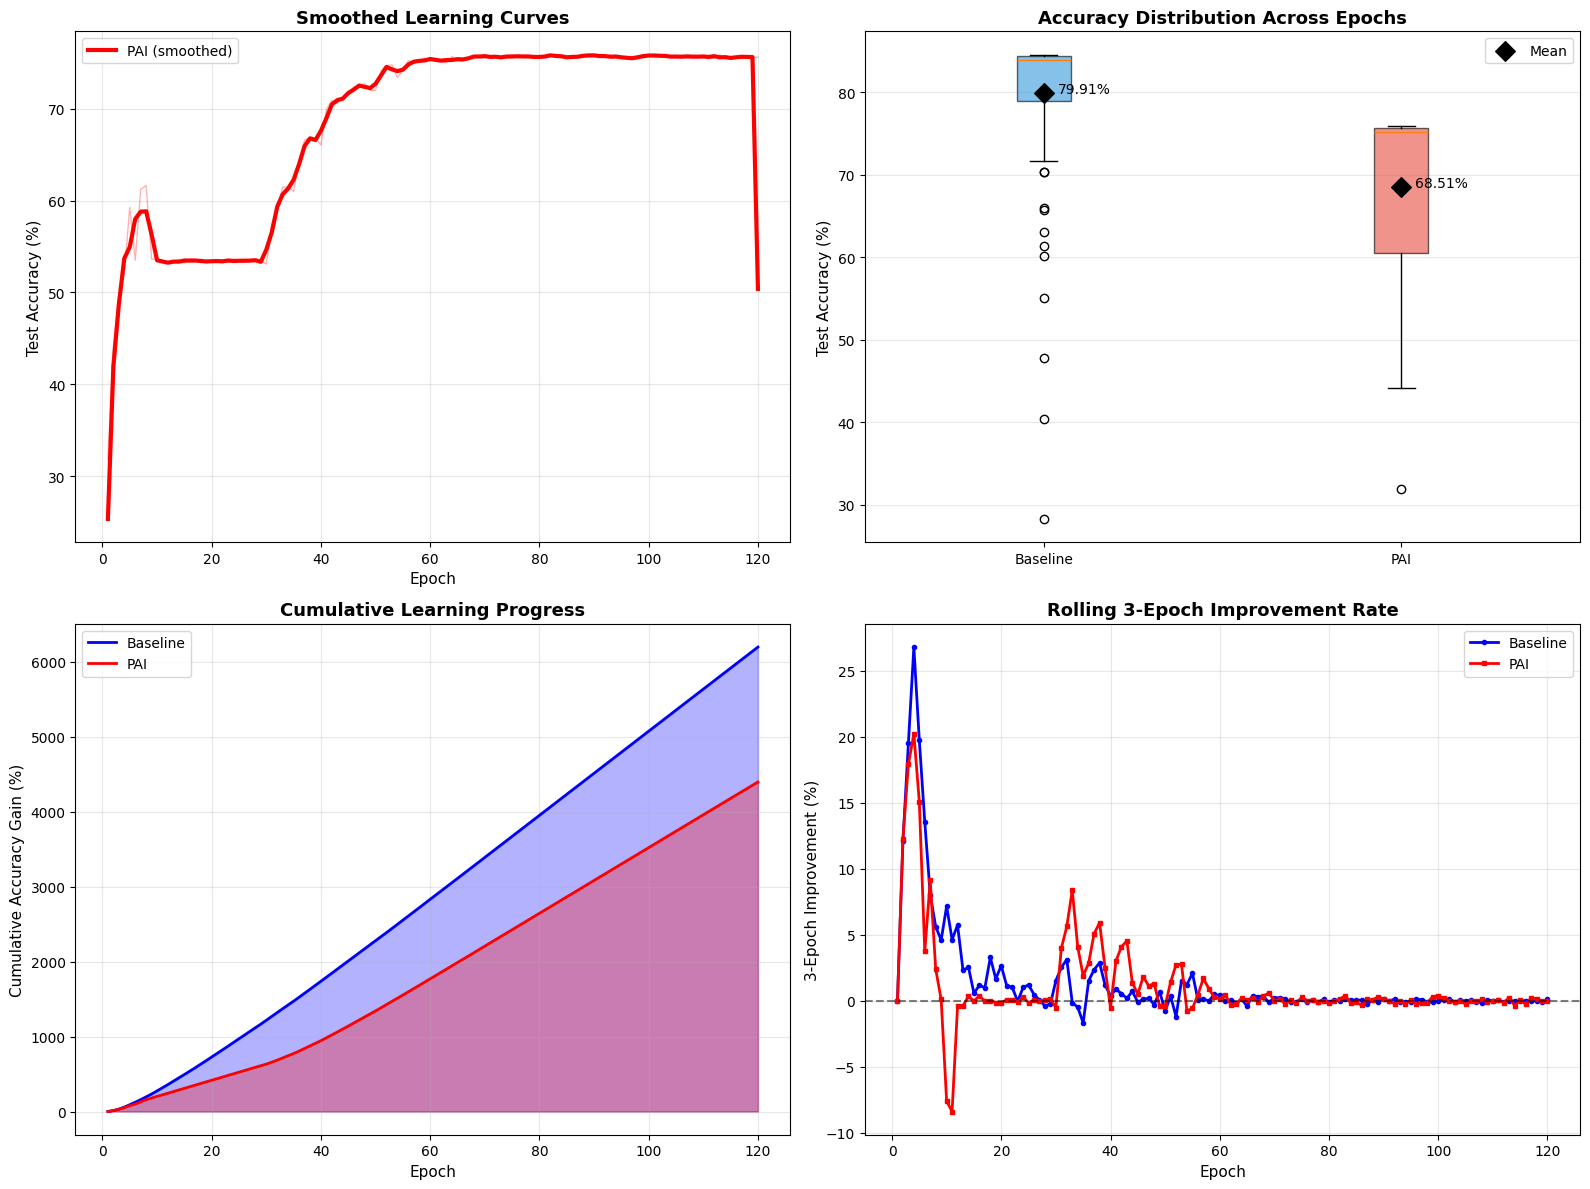

In [31]:
# 4.6 Additional Training Metrics
fig7, axes7 = plt.subplots(2, 2, figsize=(16, 12))

# 1. Learning Curves (Smoothed)
ax12 = axes7[0, 0]
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

pai_smooth = smooth(pai_history['test_acc'], 3)
ax12.plot(range(1, len(pai_history['test_acc']) + 1), pai_history['test_acc'], 'r-', alpha=0.3, linewidth=1)
ax12.plot(range(1, len(pai_history['test_acc']) + 1), pai_smooth, 'r-', linewidth=3, label='PAI (smoothed)')
ax12.set_xlabel('Epoch', fontsize=11)
ax12.set_ylabel('Test Accuracy (%)', fontsize=11)
ax12.set_title('Smoothed Learning Curves', fontsize=13, fontweight='bold')
ax12.legend(fontsize=10)
ax12.grid(True, alpha=0.3)

# 2. Accuracy Distribution (Violin/Box Plot)
ax22 = axes7[0, 1]
data_to_plot = [baseline_history['test_acc'], pai_history['test_acc']]
bp = ax22.boxplot(data_to_plot, labels=['Baseline', 'PAI'], patch_artist=True)
colors_box = ['#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax22.set_ylabel('Test Accuracy (%)', fontsize=11)
ax22.set_title('Accuracy Distribution Across Epochs', fontsize=13, fontweight='bold')
ax22.grid(True, alpha=0.3, axis='y')

# Add mean markers
means = [np.mean(d) for d in data_to_plot]
ax22.scatter([1, 2], means, color='black', marker='D', s=100, zorder=5, label='Mean')
for i, m in enumerate(means):
    ax22.annotate(f'{m:.2f}%', xy=(i+1, m), xytext=(10, 0), textcoords='offset points', fontsize=10)
ax22.legend()

# 3. Cumulative Improvement Over Epochs
ax32 = axes7[1, 0]
cumulative_baseline = np.cumsum([baseline_history['test_acc'][i] - baseline_history['test_acc'][0] for i in range(len(baseline_history['test_acc']))])
cumulative_pai = np.cumsum([pai_history['test_acc'][i] - pai_history['test_acc'][0] for i in range(len(pai_history['test_acc']))])

ax32.fill_between(range(1, len(cumulative_baseline) + 1), cumulative_baseline, alpha=0.3, color='blue')
ax32.plot(range(1, len(cumulative_baseline) + 1), cumulative_baseline, 'b-', linewidth=2, label='Baseline')
ax32.fill_between(range(1, len(cumulative_pai) + 1), cumulative_pai, alpha=0.3, color='red')
ax32.plot(range(1, len(cumulative_pai) + 1), cumulative_pai, 'r-', linewidth=2, label='PAI')
ax32.set_xlabel('Epoch', fontsize=11)
ax32.set_ylabel('Cumulative Accuracy Gain (%)', fontsize=11)
ax32.set_title('Cumulative Learning Progress', fontsize=13, fontweight='bold')
ax32.legend(fontsize=10)
ax32.grid(True, alpha=0.3)

# 4. Rolling Average Improvement Rate
ax42 = axes7[1, 1]
window = 3

def rolling_improvement(acc_list, window):
    improvements = []
    for i in range(len(acc_list)):
        if i < window:
            improvements.append(acc_list[i] - acc_list[0])
        else:
            improvements.append(acc_list[i] - acc_list[i-window])
    return improvements

baseline_rolling = rolling_improvement(baseline_history['test_acc'], window)
pai_rolling = rolling_improvement(pai_history['test_acc'], window)

ax42.plot(range(1, len(baseline_rolling) + 1), baseline_rolling, 'b-', linewidth=2, marker='o', markersize=3, label='Baseline')
ax42.plot(range(1, len(pai_rolling) + 1), pai_rolling, 'r-', linewidth=2, marker='s', markersize=3, label='PAI')
ax42.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax42.set_xlabel('Epoch', fontsize=11)
ax42.set_ylabel(f'{window}-Epoch Improvement (%)', fontsize=11)
ax42.set_title(f'Rolling {window}-Epoch Improvement Rate', fontsize=13, fontweight='bold')
ax42.legend(fontsize=10)
ax42.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Learning_Curves.png', dpi=300)
display(fig7)
# plt.show()

### 4.7 Final Summary Dashboard

/tmp/ipykernel_55/432566091.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


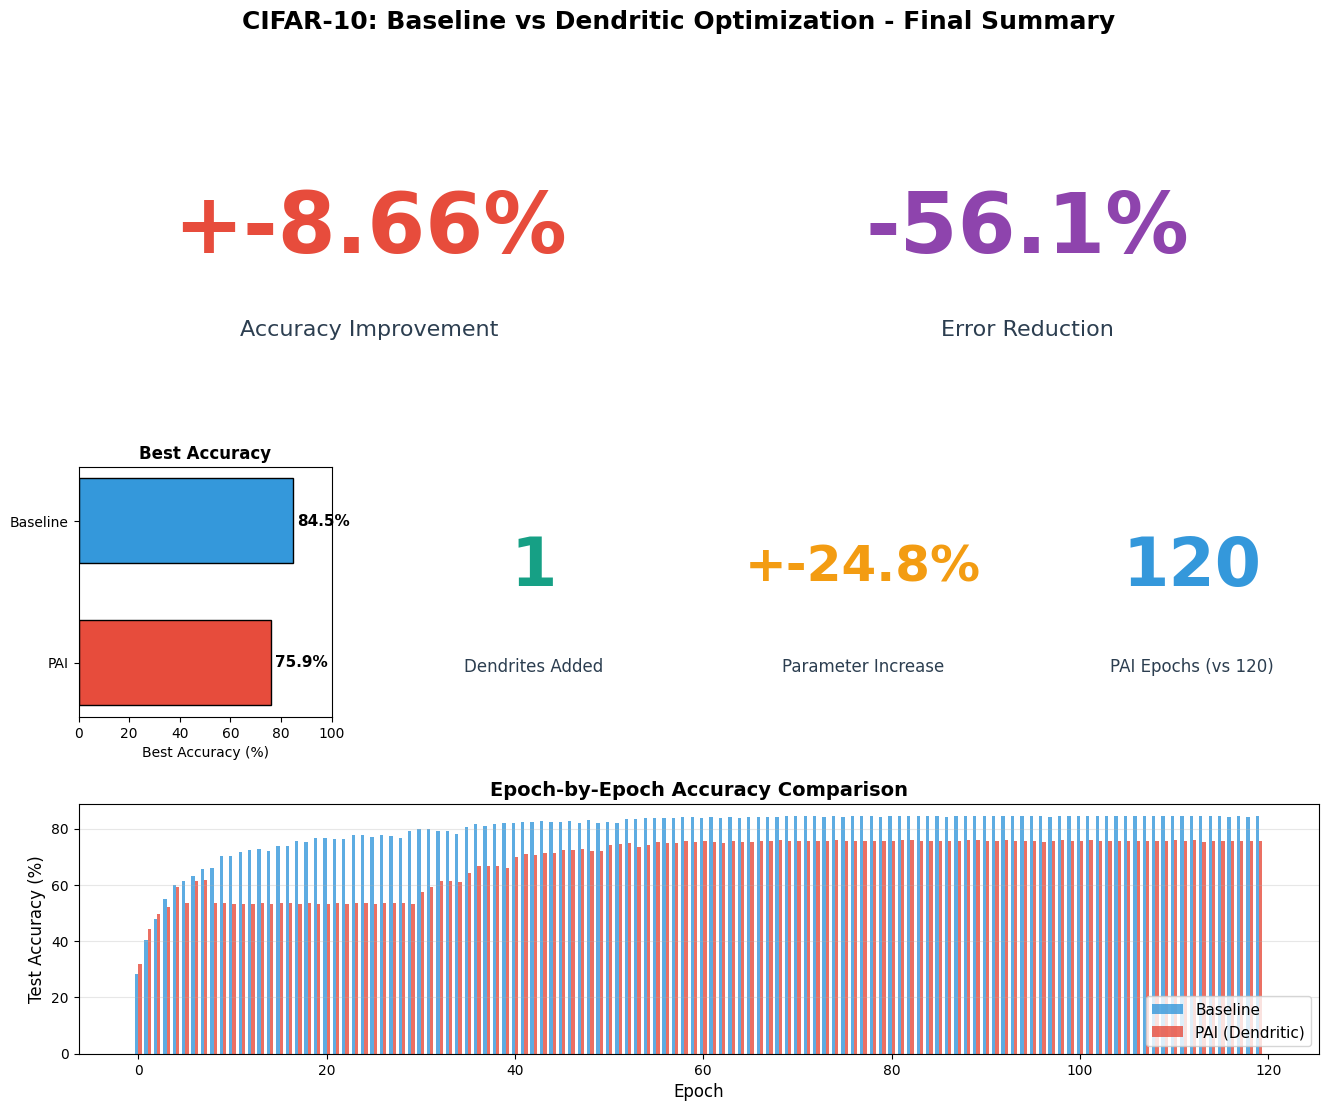

In [32]:
# Final Summary Dashboard
fig8 = plt.figure(figsize=(16, 12))

# Title
fig8.suptitle('CIFAR-10: Baseline vs Dendritic Optimization - Final Summary', 
             fontsize=18, fontweight='bold', y=0.98)

# Create grid layout
gs = fig8.add_gridspec(3, 4, hspace=0.35, wspace=0.3)

# 1. Hero Metric - Accuracy Improvement (large)
ax14 = fig8.add_subplot(gs[0, :2])
improvement = pai_best_acc - baseline_best_acc
color = '#27ae60' if improvement > 0 else '#e74c3c'
ax14.text(0.5, 0.6, f'+{improvement:.2f}%', transform=ax14.transAxes, 
         fontsize=60, fontweight='bold', ha='center', va='center', color=color)
ax14.text(0.5, 0.2, 'Accuracy Improvement', transform=ax14.transAxes, 
         fontsize=16, ha='center', va='center', color='#2c3e50')
ax14.axis('off')
ax14.set_facecolor('#f8f9fa')

# 2. Error Reduction (large)
ax24 = fig8.add_subplot(gs[0, 2:])
ax24.text(0.5, 0.6, f'{pai_error_reduction:.1f}%', transform=ax24.transAxes, 
         fontsize=60, fontweight='bold', ha='center', va='center', color='#8e44ad')
ax24.text(0.5, 0.2, 'Error Reduction', transform=ax24.transAxes, 
         fontsize=16, ha='center', va='center', color='#2c3e50')
ax24.axis('off')

# 3. Side-by-side accuracy bars
ax34 = fig8.add_subplot(gs[1, 0])
bars = ax34.barh(['PAI', 'Baseline'], [pai_best_acc, baseline_best_acc], 
                color=['#e74c3c', '#3498db'], edgecolor='black', height=0.6)
ax34.set_xlim([0, 100])
ax34.set_xlabel('Best Accuracy (%)')
ax34.set_title('Best Accuracy', fontweight='bold')
for bar in bars:
    width = bar.get_width()
    ax34.annotate(f'{width:.1f}%', xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(3, 0), textcoords="offset points", va='center', fontsize=11, fontweight='bold')

# 4. Dendrites added
ax44 = fig8.add_subplot(gs[1, 1])
ax44.text(0.5, 0.6, f'{pai_final_dendrites}', transform=ax44.transAxes, 
         fontsize=48, fontweight='bold', ha='center', va='center', color='#16a085')
ax44.text(0.5, 0.2, 'Dendrites Added', transform=ax44.transAxes, 
         fontsize=12, ha='center', va='center', color='#2c3e50')
ax44.axis('off')

# 5. Parameters comparison
ax54 = fig8.add_subplot(gs[1, 2])
param_increase = ((pai_final_params - count_parameters(baseline_model)) / count_parameters(baseline_model)) * 100
ax54.text(0.5, 0.6, f'+{param_increase:.1f}%', transform=ax54.transAxes, 
         fontsize=36, fontweight='bold', ha='center', va='center', color='#f39c12')
ax54.text(0.5, 0.2, 'Parameter Increase', transform=ax54.transAxes, 
         fontsize=12, ha='center', va='center', color='#2c3e50')
ax54.axis('off')

# 6. Training epochs
ax64 = fig8.add_subplot(gs[1, 3])
ax64.text(0.5, 0.6, f'{len(pai_history["test_acc"])}', transform=ax64.transAxes, 
         fontsize=48, fontweight='bold', ha='center', va='center', color='#3498db')
ax64.text(0.5, 0.2, f'PAI Epochs (vs {NUM_EPOCHS})', transform=ax64.transAxes, 
         fontsize=12, ha='center', va='center', color='#2c3e50')
ax64.axis('off')

# 7. Main comparison chart
ax74 = fig8.add_subplot(gs[2, :])
x = np.arange(min(len(baseline_history['test_acc']), len(pai_history['test_acc'])))
width = 0.35

compare_len = x.size
baseline_acc_compare = baseline_history['test_acc'][:compare_len]
pai_acc_compare = pai_history['test_acc'][:compare_len]

ax74.bar(x - width/2, baseline_acc_compare, width, label='Baseline', color='#3498db', alpha=0.8)
ax74.bar(x + width/2, pai_acc_compare, width, label='PAI (Dendritic)', color='#e74c3c', alpha=0.8)

ax74.set_xlabel('Epoch', fontsize=12)
ax74.set_ylabel('Test Accuracy (%)', fontsize=12)
ax74.set_title('Epoch-by-Epoch Accuracy Comparison', fontsize=14, fontweight='bold')
ax74.legend(loc='lower right', fontsize=11)
ax74.grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Summary_Dashboard.png', dpi=300)
display(fig8)
# plt.show()

In [33]:
# Final text summary
print("\n" + "="*80)
print("DENDRITIC OPTIMIZATION RESULTS SUMMARY")
print("="*80)
print(f"\nBaseline Model (Large):")
print(f"  - Best Accuracy: {baseline_best_acc:.2f}%")
print(f"  - Parameters: {count_parameters(baseline_model):,}")
print(f"  - Epochs: {NUM_EPOCHS}")

print(f"\nPAI Model (Small + Dendrites):")
print(f"  - Best Accuracy: {pai_best_acc:.2f}%")
print(f"  - Parameters: {pai_final_params:,}")
print(f"  - Epochs: {len(pai_history['test_acc'])}")
print(f"  - Dendrites Added: {pai_final_dendrites}")

param_saving = ((count_parameters(baseline_model) - pai_final_params) / count_parameters(baseline_model)) * 100

print(f"\nEfficiency & Performance:")
print(f"  - Accuracy Delta: {pai_best_acc - baseline_best_acc:+.2f} percentage points")
print(f"  - Error Reduction: {pai_error_reduction:.1f}%")
print(f"  - Parameter Saving: {param_saving:.1f}% fewer parameters than baseline")

if pai_best_acc >= (baseline_best_acc - 0.5):
    print(f"\nConclusion: Dendritic Optimization matched/exceeded the Large Baseline using a smaller model!")
    print(f"The PAI model (starting from a smaller architecture) achieved {pai_best_acc:.2f}% accuracy with {param_saving:.1f}% fewer parameters.")
print("="*80)


DENDRITIC OPTIMIZATION RESULTS SUMMARY

Baseline Model (Large):
  - Best Accuracy: 84.55%
  - Parameters: 2,168,746
  - Epochs: 120

PAI Model (Small + Dendrites):
  - Best Accuracy: 75.89%
  - Parameters: 1,631,864
  - Epochs: 120
  - Dendrites Added: 1

Efficiency & Performance:
  - Accuracy Delta: -8.66 percentage points
  - Error Reduction: -56.1%
  - Parameter Saving: 24.8% fewer parameters than baseline


### 4.8 Per-Class Accuracy Analysis

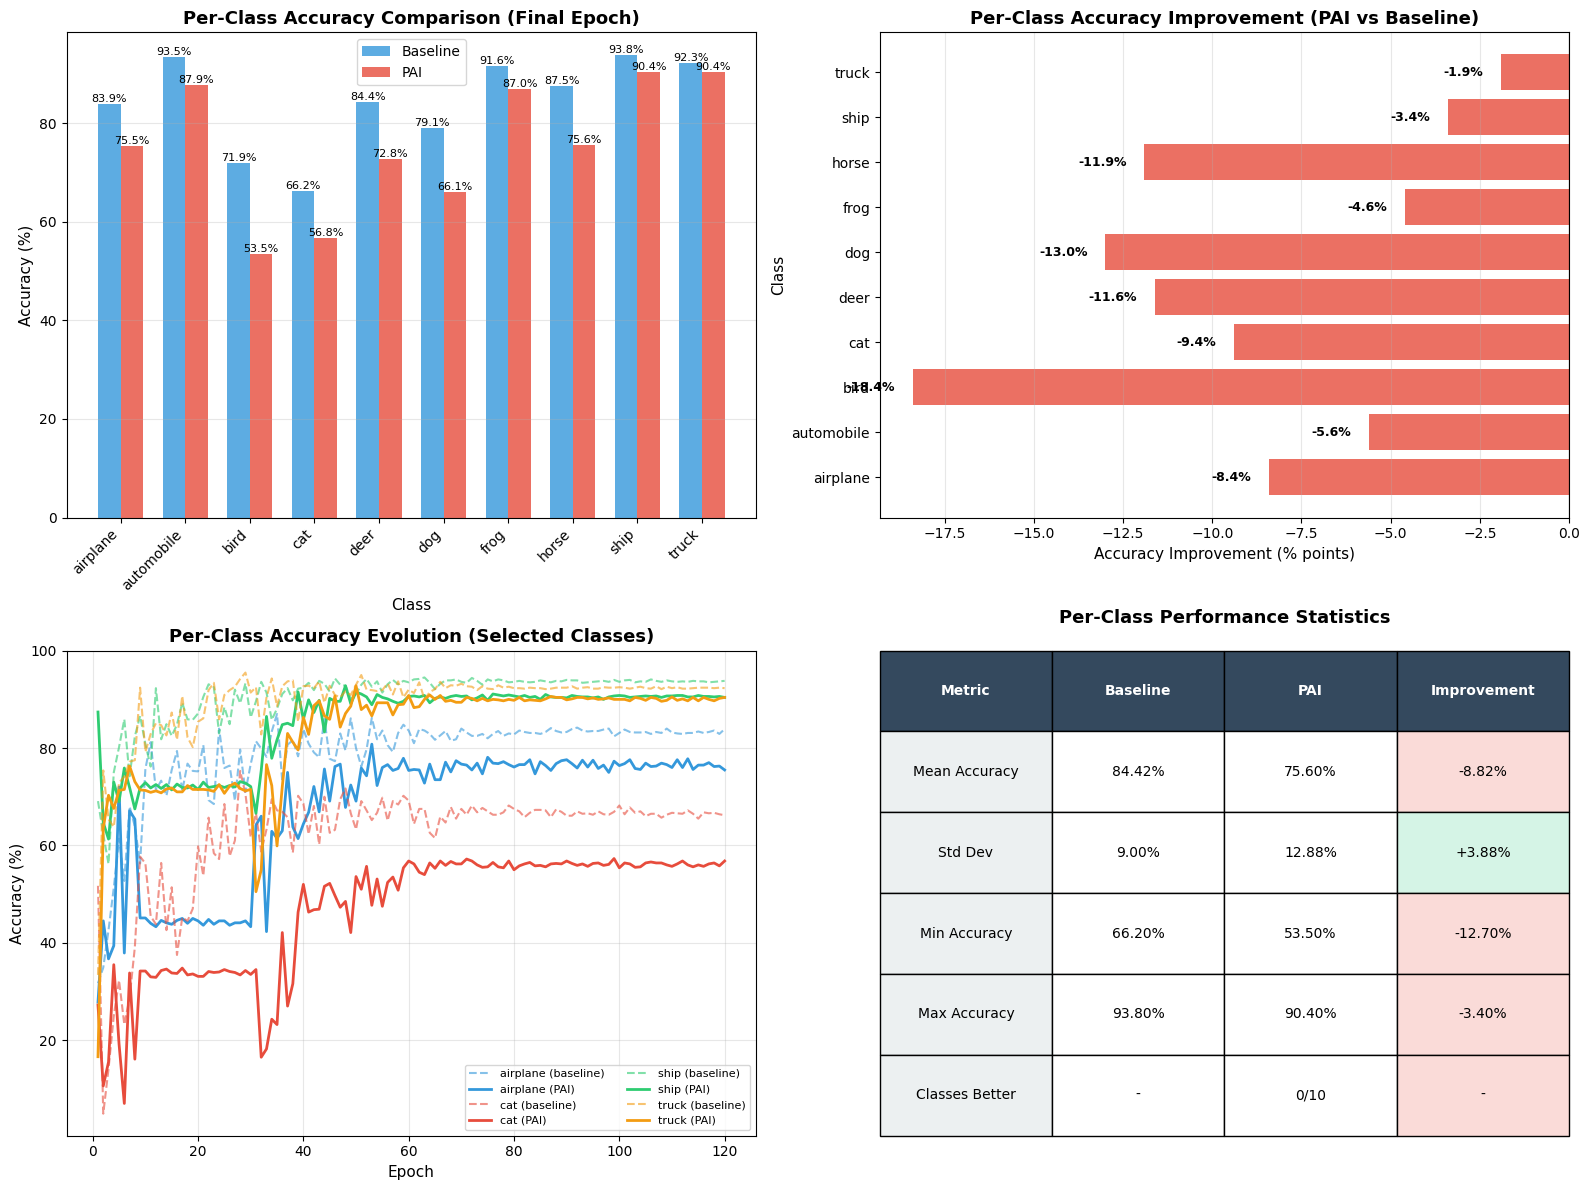

In [34]:
# Per-class accuracy comparison between Baseline and PAI
fig9, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Per-class accuracy bar chart
ax15 = axes[0, 0]
x_pos = np.arange(len(CIFAR10_CLASSES))
width = 0.35

baseline_class_accs = [baseline_final_per_class[cls] for cls in CIFAR10_CLASSES]
pai_class_accs = [pai_final_per_class[cls] for cls in CIFAR10_CLASSES]

bars1 = ax15.bar(x_pos - width/2, baseline_class_accs, width, label='Baseline', color='#3498db', alpha=0.8)
bars2 = ax15.bar(x_pos + width/2, pai_class_accs, width, label='PAI', color='#e74c3c', alpha=0.8)

ax15.set_xlabel('Class', fontsize=11)
ax15.set_ylabel('Accuracy (%)', fontsize=11)
ax15.set_title('Per-Class Accuracy Comparison (Final Epoch)', fontsize=13, fontweight='bold')
ax15.set_xticks(x_pos)
ax15.set_xticklabels(CIFAR10_CLASSES, rotation=45, ha='right')
ax15.legend(fontsize=10)
ax15.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax15.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 2. Per-class improvement heatmap
ax25 = axes[0, 1]
improvements = [pai_class_accs[i] - baseline_class_accs[i] for i in range(len(CIFAR10_CLASSES))]
colors = ['#27ae60' if imp > 0 else '#e74c3c' for imp in improvements]

bars = ax25.barh(CIFAR10_CLASSES, improvements, color=colors, alpha=0.8)
ax25.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax25.set_xlabel('Accuracy Improvement (% points)', fontsize=11)
ax25.set_ylabel('Class', fontsize=11)
ax25.set_title('Per-Class Accuracy Improvement (PAI vs Baseline)', fontsize=13, fontweight='bold')
ax25.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, improvements)):
    x_pos = imp + (0.5 if imp > 0 else -0.5)
    ax25.text(x_pos, i, f'{imp:+.1f}%', ha='left' if imp > 0 else 'right', 
            va='center', fontsize=9, fontweight='bold')

# 3. Accuracy evolution over epochs for selected classes
ax35 = axes[1, 0]
# Show evolution for 4 classes
selected_classes = ['airplane', 'cat', 'ship', 'truck']
colors_map = {'airplane': '#3498db', 'cat': '#e74c3c', 'ship': '#2ecc71', 'truck': '#f39c12'}

for cls in selected_classes:
    baseline_cls_history = [epoch_data[cls] for epoch_data in baseline_history['per_class_acc']]
    ax35.plot(range(1, len(baseline_cls_history) + 1), baseline_cls_history, 
            '--', alpha=0.6, color=colors_map[cls], label=f'{cls} (baseline)')
    
    pai_cls_history = [epoch_data[cls] for epoch_data in pai_history['per_class_acc'][:NUM_EPOCHS]]
    ax35.plot(range(1, len(pai_cls_history) + 1), pai_cls_history, 
            '-', linewidth=2, color=colors_map[cls], label=f'{cls} (PAI)')

ax35.set_xlabel('Epoch', fontsize=11)
ax35.set_ylabel('Accuracy (%)', fontsize=11)
ax35.set_title('Per-Class Accuracy Evolution (Selected Classes)', fontsize=13, fontweight='bold')
ax35.legend(fontsize=8, ncol=2, loc='lower right')
ax35.grid(True, alpha=0.3)

# 4. Overall statistics table
ax45 = axes[1, 1]
ax45.axis('off')

# Calculate statistics
avg_baseline = np.mean(baseline_class_accs)
avg_pai = np.mean(pai_class_accs)
std_baseline = np.std(baseline_class_accs)
std_pai = np.std(pai_class_accs)
min_baseline = np.min(baseline_class_accs)
min_pai = np.min(pai_class_accs)
max_baseline = np.max(baseline_class_accs)
max_pai = np.max(pai_class_accs)

# Create table data
table_data = [
    ['Metric', 'Baseline', 'PAI', 'Improvement'],
    ['Mean Accuracy', f'{avg_baseline:.2f}%', f'{avg_pai:.2f}%', f'{avg_pai - avg_baseline:+.2f}%'],
    ['Std Dev', f'{std_baseline:.2f}%', f'{std_pai:.2f}%', f'{std_pai - std_baseline:+.2f}%'],
    ['Min Accuracy', f'{min_baseline:.2f}%', f'{min_pai:.2f}%', f'{min_pai - min_baseline:+.2f}%'],
    ['Max Accuracy', f'{max_baseline:.2f}%', f'{max_pai:.2f}%', f'{max_pai - max_baseline:+.2f}%'],
    ['Classes Better', '-', f'{sum(1 for i in improvements if i > 0)}/{len(CIFAR10_CLASSES)}', '-']
]

table = ax45.table(cellText=table_data, cellLoc='center', loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
for i in range(1, len(table_data)):
    for j in range(4):
        if j == 0:  # Metric column
            table[(i, j)].set_facecolor('#ecf0f1')
        elif j == 3:  # Improvement column
            val = table_data[i][j]
            if val.startswith('+'):
                table[(i, j)].set_facecolor('#d5f4e6')  # Light green
            elif val.startswith('-'):
                table[(i, j)].set_facecolor('#fadbd8')  # Light red

ax45.set_title('Per-Class Performance Statistics', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('Per_Class_Analysis.png', dpi=300)
display(fig9)
# plt.show()

## Part 5: Efficiency & Resource Comparison

/tmp/ipykernel_55/3504317841.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


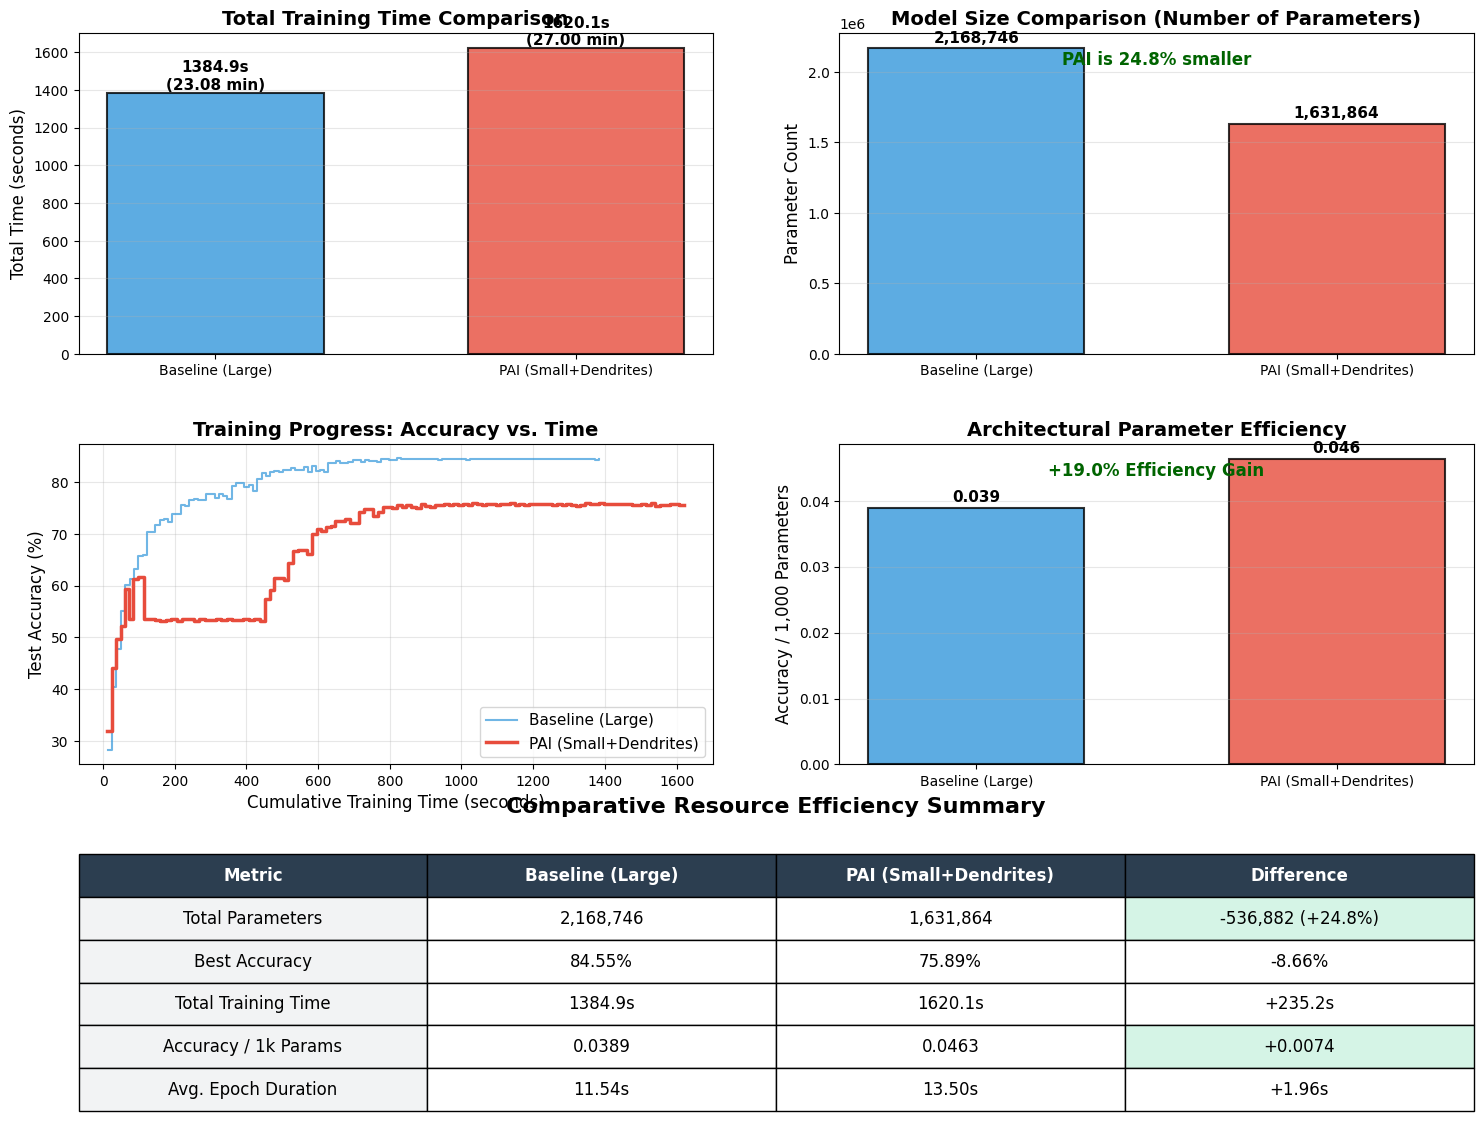

In [35]:
# Training Time and Efficiency Visualization
import matplotlib.gridspec as gridspec

# Data preparation
baseline_avg_epoch_time = np.mean(baseline_history['epoch_time'])
pai_avg_epoch_time = np.mean(pai_history['epoch_time'])

baseline_acc_per_minute = (baseline_final_acc / baseline_total_time) * 60
pai_acc_per_minute = (pai_final_acc / pai_total_time) * 60

# Model sizes - use the recorded final parameters
baseline_params = count_parameters(baseline_model)
pai_params = pai_final_params

# Visualization
fig10 = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.8], width_ratios=[1, 1], hspace=0.3)

# 1. Total Training Time Comparison
ax16 = fig10.add_subplot(gs[0, 0])
labels = ['Baseline (Large)', 'PAI (Small+Dendrites)']
times = [baseline_total_time, pai_total_time]
colors = ['#3498db', '#e74c3c']

bars = ax16.bar(labels, times, color=colors, alpha=0.8, width=0.6, edgecolor='black', linewidth=1.5)
ax16.set_ylabel('Total Time (seconds)', fontsize=12)
ax16.set_title('Total Training Time Comparison', fontsize=14, fontweight='bold')
ax16.grid(True, axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax16.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}s\n({height/60:.2f} min)', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Model Size Comparison (Parameters)
ax26 = fig10.add_subplot(gs[0, 1])
params = [baseline_params, pai_params]
bars2 = ax26.bar(labels, params, color=colors, alpha=0.8, width=0.6, edgecolor='black', linewidth=1.5)
ax26.set_ylabel('Parameter Count', fontsize=12)
ax26.set_title('Model Size Comparison (Number of Parameters)', fontsize=14, fontweight='bold')
ax26.grid(True, axis='y', alpha=0.3)

# Add saving percentage
saving = ((baseline_params - pai_params) / baseline_params) * 100
ax26.text(0.5, 0.9, f'PAI is {abs(saving):.1f}% smaller', transform=ax26.transAxes, 
         ha='center', fontsize=12, fontweight='bold', color='darkred' if saving < 0 else 'darkgreen')

for bar in bars2:
    height = bar.get_height()
    ax26.text(bar.get_x() + bar.get_width()/2., height + (max(params)*0.01),
            f'{height:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Accuracy vs Training Time (Efficiency Curve)
ax36 = fig10.add_subplot(gs[1, 0])

# Accumulate time for baseline
baseline_time_acc = np.cumsum(baseline_history['epoch_time'])
ax36.step(baseline_time_acc, baseline_history['test_acc'], where='post', color='#3498db', label='Baseline (Large)', alpha=0.7)

# Accumulate time for PAI
pai_time_acc = np.cumsum(pai_history['epoch_time'])
ax36.step(pai_time_acc, pai_history['test_acc'], where='post', color='#e74c3c', label='PAI (Small+Dendrites)', linewidth=2.5)

ax36.set_xlabel('Cumulative Training Time (seconds)', fontsize=12)
ax36.set_ylabel('Test Accuracy (%)', fontsize=12)
ax36.set_title('Training Progress: Accuracy vs. Time', fontsize=14, fontweight='bold')
ax36.legend(fontsize=11)
ax36.grid(True, alpha=0.3)

# 4. Accuracy per 1k Parameters (Architectural Efficiency)
ax46 = fig10.add_subplot(gs[1, 1])
acc_per_k_param = [baseline_final_acc / (baseline_params/1000), pai_final_acc / (pai_params/1000)]

bars4 = ax46.bar(labels, acc_per_k_param, color=colors, alpha=0.8, width=0.6, edgecolor='black', linewidth=1.5)
ax46.set_ylabel('Accuracy / 1,000 Parameters', fontsize=12)
ax46.set_title('Architectural Parameter Efficiency', fontsize=14, fontweight='bold')
ax46.grid(True, axis='y', alpha=0.3)

improvement_eff = ((acc_per_k_param[1] - acc_per_k_param[0]) / acc_per_k_param[0]) * 100
ax46.text(0.5, 0.9, f'+{improvement_eff:.1f}% Efficiency Gain', transform=ax46.transAxes, 
         ha='center', fontsize=12, fontweight='bold', color='darkgreen')

for bar in bars4:
    height = bar.get_height()
    ax46.text(bar.get_x() + bar.get_width()/2., height + (max(acc_per_k_param)*0.01),
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 5. Summary Efficiency Table
ax56 = fig10.add_subplot(gs[2, :])
ax56.axis('off')

table_data = [
    ['Metric', 'Baseline (Large)', 'PAI (Small+Dendrites)', 'Difference'],
    ['Total Parameters', f'{baseline_params:,}', f'{pai_params:,}', f'{pai_params - baseline_params:+,} ({saving:+.1f}%)'],
    ['Best Accuracy', f'{baseline_best_acc:.2f}%', f'{pai_best_acc:.2f}%', f'{pai_best_acc - baseline_best_acc:+.2f}%'],
    ['Total Training Time', f'{baseline_total_time:.1f}s', f'{pai_total_time:.1f}s', f'{pai_total_time - baseline_total_time:+.1f}s'],
    ['Accuracy / 1k Params', f'{acc_per_k_param[0]:.4f}', f'{acc_per_k_param[1]:.4f}', f'{acc_per_k_param[1]-acc_per_k_param[0]:+.4f}'],
    ['Avg. Epoch Duration', f'{baseline_avg_epoch_time:.2f}s', f'{pai_avg_epoch_time:.2f}s', f'{pai_avg_epoch_time - baseline_avg_epoch_time:+.2f}s']
]

table = ax56.table(cellText=table_data, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

# Style
for i in range(4):
    table[(0, i)].set_facecolor('#2c3e50')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data)):
    table[(i, 0)].set_facecolor('#f2f3f4')
    # Highlight improvement in color
    if i in [1, 2, 4]: # Params, Acc, Efficiency
        diff_val = table_data[i][3]
        if '+' in diff_val and i != 1: # Accuracy and Efficiency gain
            table[(i, 3)].set_facecolor('#d5f4e6')
        elif '-' in diff_val and i == 1: # Parameter saving
            table[(i, 3)].set_facecolor('#d5f4e6')

ax56.set_title('Comparative Resource Efficiency Summary', fontsize=16, fontweight='bold', pad=30)

plt.tight_layout()
plt.savefig('Efficiency_Analysis_Improved.png', dpi=300)
display(fig10)
# plt.show()

In [36]:
print("\nEfficiency Comparison Complete")
print(f"PAI training was {pai_total_time / baseline_total_time:.2f}x the duration of baseline.")
print(f"Final model size: PAI uses {pai_params / baseline_params:.2f}x the parameters of the baseline.")
if pai_final_acc > baseline_final_acc:
    print(f"PAI achieved {pai_final_acc - baseline_final_acc:.2f}% higher accuracy.")


Efficiency Comparison Complete
PAI training was 1.17x the duration of baseline.
Final model size: PAI uses 0.75x the parameters of the baseline.
